# Recommendation System

This notebook is about prediction the duration and density of customer sessions in an on-line system.

Each session has informaiton on its `duraiton` and on the number of actions done by the customer during this session (`actions_in_session`). The normalized actions are represented by the `density`, which is the number of actions in a minute.

## Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_rows', None)

In [3]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=933265 sha256=a2d51ea6b3b367f5ef4ab6f02461737616c24b81c9c1fad9b5bfb7c1dc2c449d
  Stored in directory: /root/.cache/pip/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit


In [4]:
from datetime import datetime
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from scipy.sparse import csr_matrix
import implicit
from implicit.als import AlternatingLeastSquares
from tqdm import tqdm

In [5]:
df = pd.read_csv("/content/drive/My Drive/collaborative_filtering/sessions.csv")
print(f"Loaded {len(df)} sessions")
df.head()

Loaded 1000000 sessions


,customer,time,duration,actions_in_session,density
0,13996117415,2021-02-12 02:56:35+00:00,1.25,7,5.60
1,12734718207,2021-01-22 12:08:23+00:00,30.34,181,5.97
2,14125989847,2021-01-30 21:29:55+00:00,5.98,50,8.36
3,10042558183,2021-02-04 15:49:13+00:00,10.86,50,4.60
4,13728624671,2021-01-26 19:33:57+00:00,2.96,12,4.05


In [6]:
# Parse time
df['time'] = pd.to_datetime(df['time'])

In [8]:
df['time'].min()

Timestamp('2021-01-15 00:00:04+0000', tz='UTC')

In [9]:
df['time'].max()

Timestamp('2021-02-15 23:59:58+0000', tz='UTC')

In [10]:
df.shape

(1000000, 5)

In [11]:
df['duration'].max()

20000.57

In [12]:
df['density'].max()

24.49

---

## Round Duraitons

I want to round the durations to have much less unique duraions, and hence higher matrix density.

In [7]:
df['orig_duration'] = df['duration']
df['orig_density'] = df['density']

In [8]:
df['duration'] = df['orig_duration'].round(0)
df['density'] = df['actions_in_session'] / df['duration']

In [9]:
df.head()

,customer,time,duration,actions_in_session,density,orig_duration,orig_density
0,13996117415,2021-02-12 02:56:35+00:00,1.0,7,7.000000,1.25,5.60
1,12734718207,2021-01-22 12:08:23+00:00,30.0,181,6.033333,30.34,5.97
2,14125989847,2021-01-30 21:29:55+00:00,6.0,50,8.333333,5.98,8.36
3,10042558183,2021-02-04 15:49:13+00:00,11.0,50,4.545455,10.86,4.60
4,13728624671,2021-01-26 19:33:57+00:00,3.0,12,4.000000,2.96,4.05


In [10]:
df['density'] = df['density'].round(0)

In [11]:
df.head()

,customer,time,duration,actions_in_session,density,orig_duration,orig_density
0,13996117415,2021-02-12 02:56:35+00:00,1.0,7,7.0,1.25,5.60
1,12734718207,2021-01-22 12:08:23+00:00,30.0,181,6.0,30.34,5.97
2,14125989847,2021-01-30 21:29:55+00:00,6.0,50,8.0,5.98,8.36
3,10042558183,2021-02-04 15:49:13+00:00,11.0,50,5.0,10.86,4.60
4,13728624671,2021-01-26 19:33:57+00:00,3.0,12,4.0,2.96,4.05


---

## Exploration

**I am exploring the data so that I would be able to define the key design questions:**
- What is the "item" in our recommendation system? Duration? density? A combinaiton (duration, density)?
- Should we bucket durations or density values into tiers?
- Does each user have multiple duration tranactions? Do I need a binary or frequent (count) matrix?
- How sparse is the data? Do we have enough data per user? Is collaborative filtering viable given the data sparsity?

### Dataset Scale & Sparsity

How many customers, unique combinations, total combinations? What's the user-combination matrix density?

This determines if collaborative filtering is viable (need sufficient overlap between users).

In [19]:
# Check basic figures
n_users = df['customer'].nunique()
n_transactions = len(df)
n_unique_durations = df['duration'].nunique()
n_unique_density = df['density'].nunique()

# Create comb as (duration, density) tuple
df['comb'] = list(zip(df['duration'], df['density']))
n_unique_combs = df['comb'].nunique()

print("=== Dataset Scale ===")
print(f"Total transactions: {n_transactions:,}")
print(f"Unique users: {n_users:,}")
print(f"Unique durations: {n_unique_durations}")
print(f"Unique density values: {n_unique_density}")
print(f"Unique (duration, density) combs: {n_unique_combs}")

print("\n=== Sparsity Analysis ===")

# User-duration matrix
user_duration_density = n_transactions / (n_users * n_unique_durations) * 100
print(f"User-duration matrix: {n_users} x {n_unique_durations} = {n_users * n_unique_durations:,} cells")
print(f"  Density: {user_duration_density:.2f}%")

# User-comb matrix
user_comb_density = n_transactions / (n_users * n_unique_combs) * 100
print(f"User-comb matrix: {n_users} x {n_unique_combs} = {n_users * n_unique_combs:,} cells")
print(f"  Density: {user_comb_density:.2f}%")

=== Dataset Scale ===
Total transactions: 1,000,000
Unique users: 119,713
Unique durations: 99
Unique density values: 18
Unique (duration, density) combs: 375

=== Sparsity Analysis ===
User-duration matrix: 119713 x 99 = 11,851,587 cells
  Density: 8.44%
User-comb matrix: 119713 x 375 = 44,892,375 cells
  Density: 2.23%


**The customer-duration matrix has density of ~8% which is relatively high! Also, the user-comb is also sufficient with ~2%.**

### Duration vs density

Visualizing the joint distribution of duration and density to understand the structure of the comb space.

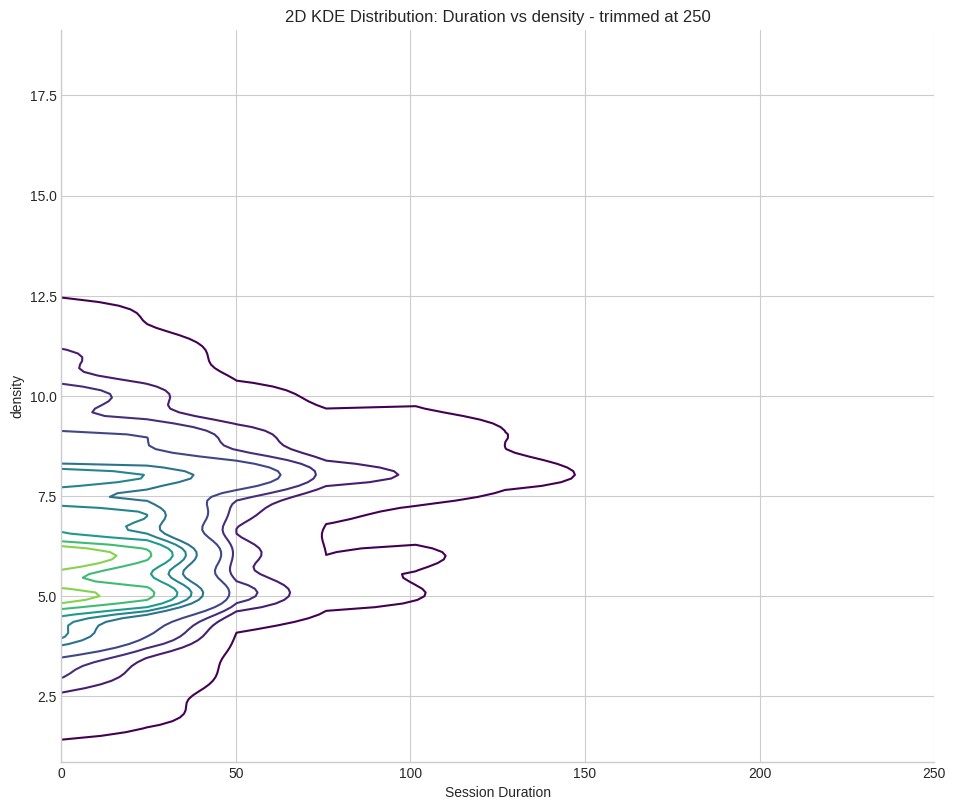

In [19]:
# Below are 2 charts. I separated the main population and some high duration / high density population

# Sampling for histograms
df_sample = df.sample(n=20000, random_state=42)
g = sns.displot(data=df_sample, x='duration', y='density', kind='kde', fill=False, cmap='viridis', height=8, aspect=1.2)
g.set_axis_labels('Session Duration', 'density')
plt.title('2D KDE Distribution: Duration vs density - trimmed at 250')
plt.xlim(0, 250)
plt.show()

Number of high duration transactions 16513
Number of users wiht high durations 4224


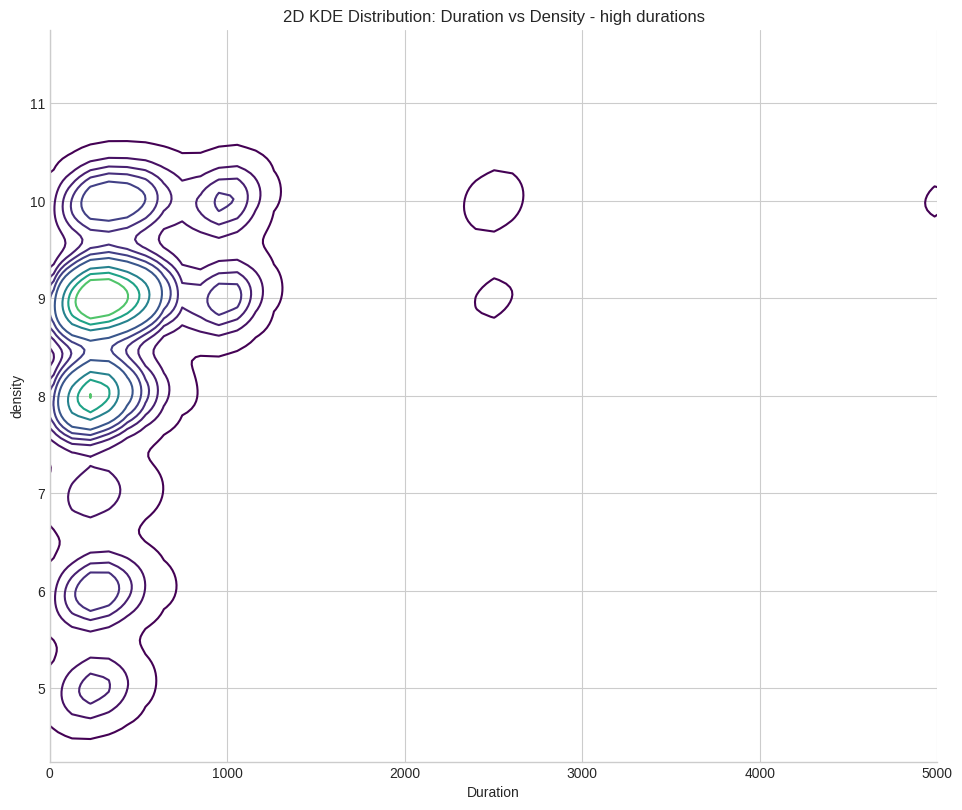

In [20]:
# High duration transactions
high_duration_df = df[df["duration"]>200]
print("Number of high duration transactions", len(high_duration_df))

print("Number of users wiht high durations", high_duration_df["customer"].nunique())

h = sns.displot(data=high_duration_df, x='duration', y='density', kind='kde', fill=False, cmap='viridis', height=8, aspect=1.2)
h.set_axis_labels('Duration', 'density')
plt.title('2D KDE Distribution: Duration vs Density - high durations')
plt.xlim(0, 5000)
plt.show()

**I see that there is a segment of high duration session. This segment has in general higher density than the main populaiton - density are concentrated around 8-10.**

### Customer Activity Distribution

**Purpose:** Histogram of sessions per user. Are there power customers vs. one-timers?

In [21]:
# Number of purchased per user
sessions_per_user = df.groupby('customer').size()

POWER_USER_THRESHOLD = 10

print(f"\nOne-timers: {(sessions_per_user == 1).sum()} ({(sessions_per_user == 1).mean()*100:.1f}%)")
print(f"Users with 2-5 purchases: {((sessions_per_user >= 2) & (sessions_per_user <= POWER_USER_THRESHOLD)).sum()}")
print(f"Power users (>{POWER_USER_THRESHOLD} purchases): {(sessions_per_user > POWER_USER_THRESHOLD).sum()}")


One-timers: 8717 (7.3%)
Users with 2-5 purchases: 84920
Power users (>10 purchases): 26076


(0.0, 100.0)

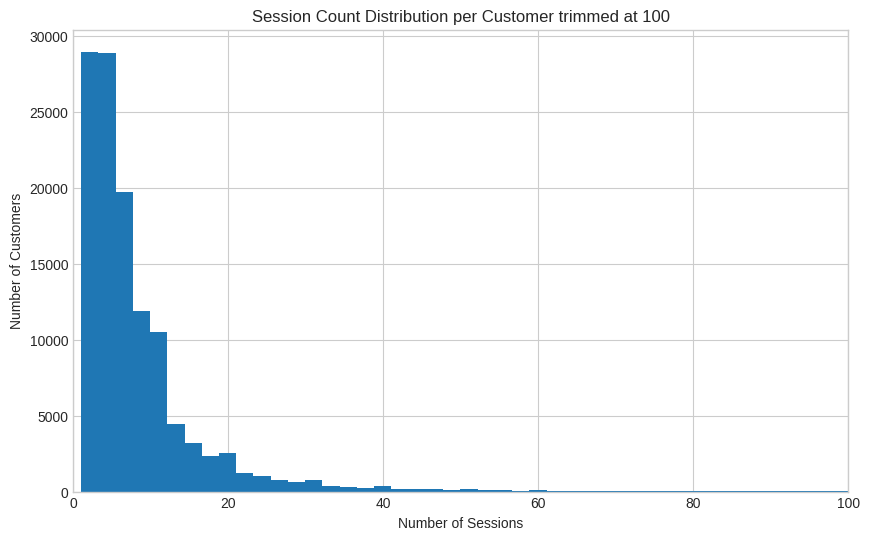

In [22]:
sessions_per_user.hist(bins=200)
# plt.yscale('log')
plt.title("Session Count Distribution per Customer trimmed at 100")
plt.xlabel("Number of Sessions")
plt.ylabel("Number of Customers")
plt.xlim(0,100)


**Majority of customers have up to 10-20 sessions. ~7% of one-timers.**

### Duration Point Popularity

Which durations are most/least prevalent?

Identifies if some durations dominate

In [23]:
# Group by duration and check cumulative percentage
duration_counts = df['duration'].value_counts().sort_index().to_frame('count').sort_values("count", ascending=False)
duration_counts["paercent_cumul"] = duration_counts["count"].cumsum() / duration_counts["count"].sum()
print(duration_counts)

           count  paercent_cumul
duration                        
2.0       231509        0.231509
1.0       120890        0.352399
3.0       111486        0.463885
10.0       67333        0.531218
11.0       63516        0.594734
5.0        49461        0.644195
6.0        48713        0.692908
50.0       36366        0.729274
51.0       34160        0.763434
20.0       28416        0.791850
21.0       26378        0.818228
30.0       20157        0.838385
31.0       19113        0.857498
100.0      17872        0.875370
101.0      16878        0.892248
25.0       12701        0.904949
26.0       12499        0.917448
8.0        12139        0.929587
9.0        11531        0.941118
15.0        8078        0.949196
16.0        7831        0.957027
200.0       4589        0.961616
201.0       4267        0.965883
40.0        4026        0.969909
41.0        3658        0.973567
250.0       2516        0.976083
4.0         2368        0.978451
251.0       2360        0.980811
150.0     

**16 durations comprise 90% of the sessions.**

### Density Distribution by duration

Boxplot of density range for each duration tier.

Clarifies the density variation pattern, see the link to duration (does each duration has a difference density range).

In [24]:
df['duration_int'] = df['duration'].astype(int)

In [25]:
# Summary stats per duration
density_by_duration = df.groupby('duration_int')['density'].agg(['min', 'max', 'mean', 'std', 'count'])
print("=== density Statistics by duration ===")
print(density_by_duration.round(2))

=== density Statistics by duration ===
               min   max   mean   std   count
duration_int                                 
0              inf   inf    inf   NaN      48
1              2.0  18.0   8.32  2.19  120890
2              2.0  16.0   5.77  2.11  231509
3              3.0  12.0   4.89  1.16  111486
4              4.0   9.0   5.88  0.81    2368
5              4.0  14.0   7.93  1.72   49461
6              4.0  11.0   6.60  1.42   48713
7              5.0   6.0   5.37  0.49      60
8              4.0   8.0   6.37  0.66   12139
9              5.0   7.0   5.70  0.62   11531
10             5.0  11.0   6.54  1.38   67333
11             4.0  10.0   6.04  1.16   63516
12             6.0   6.0   6.00  0.00       2
13             6.0   6.0   6.00  0.00       2
14             6.0   6.0   6.00  0.00       4
15             5.0  10.0   6.39  1.51    8078
16             5.0  10.0   6.25  1.39    7831
19             5.0   5.0   5.00   NaN       1
20             5.0  10.0   6.70  1.64   2

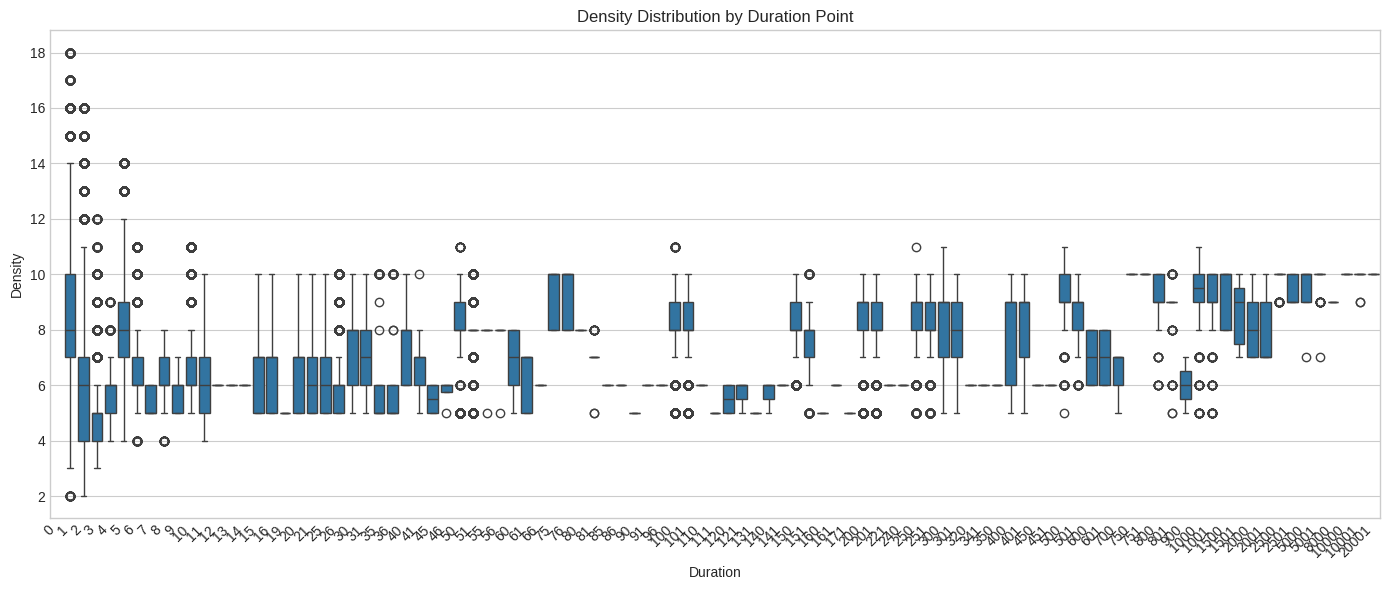

In [26]:
# Boxplot
plt.figure(figsize=(14, 6))
sorted_durations = sorted(df['duration_int'].unique())
sns.boxplot(data=df, x='duration_int', y='density', order=sorted_durations)
plt.xlabel('Duration')
plt.ylabel('Density')
plt.title('Density Distribution by Duration Point')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

I see some interesting things:
- The lowest duration (1 minute) has relatively high density
- We see the high durations segment with high density on the top right (as we saw earlier)

### Customer Duration Preference Consistency

**Purpose:** Do users stick to certain duration tiers?

If yes, duration-based segmentation may work; if not, need finer modeling.

In [27]:
# Filter to users with 2+ sessions
user_duration_variety = df.groupby('customer').agg(
    n_sessions=('duration', 'count'),
    n_unique_durations=('duration', 'nunique')
)
user_duration_variety = user_duration_variety[user_duration_variety['n_sessions'] >= 2]
user_duration_variety['variety_ratio'] = user_duration_variety['n_unique_durations'] / user_duration_variety['n_sessions']

print("=== Normalized Duration Variety (users with 2+ sessions) ===")
print(f"Users analyzed: {len(user_duration_variety)}")
print(user_duration_variety['variety_ratio'].describe())

print(f"\nInterpretation:")
print(f"  Ratio = 1.0: every sessions is a different duration (max variety)")
print(f"  Ratio → 0.0: user sticks to same duration(s) repeatedly (low variety)")

=== Normalized Duration Variety (users with 2+ sessions) ===
Users analyzed: 110996
count    110996.000000
mean          0.570115
std           0.253447
min           0.011594
25%           0.375000
50%           0.538462
75%           0.750000
max           1.000000
Name: variety_ratio, dtype: float64

Interpretation:
  Ratio = 1.0: every sessions is a different duration (max variety)
  Ratio → 0.0: user sticks to same duration(s) repeatedly (low variety)


In [28]:
user_duration_variety.head()

,n_sessions,n_unique_durations,variety_ratio
customer,,,
38763,5,4,0.800000
102195,7,3,0.428571
120491,22,8,0.363636
228103,5,4,0.800000
347903,4,4,1.000000


In [29]:
user_duration_variety[user_duration_variety["variety_ratio"]<0.1]

,n_sessions,n_unique_durations,variety_ratio
customer,,,
2672887,98,6,0.061224
108253859,22,2,0.090909
163971715,32,3,0.093750
286600591,112,3,0.026786
298111455,55,3,0.054545
329119863,30,2,0.066667
368246511,39,3,0.076923
451869471,64,5,0.078125
467510839,37,3,0.081081


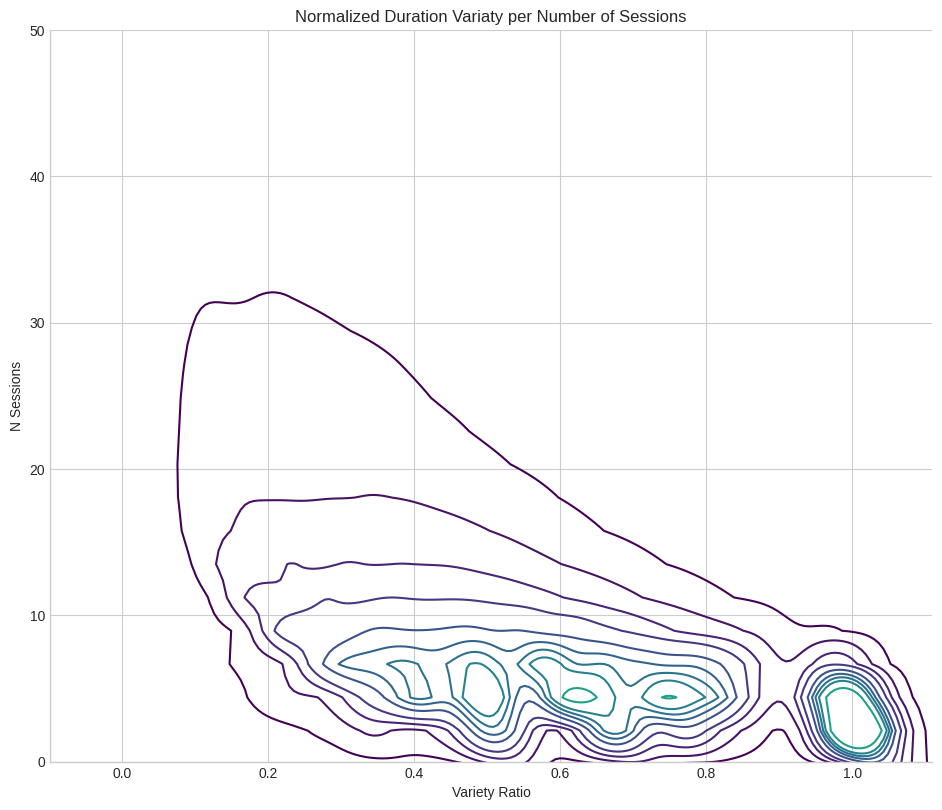

In [30]:
# Plot both variety ratio and the number of sessions
g = sns.displot(data=user_duration_variety, x='variety_ratio', y='n_sessions', kind='kde', fill=False, cmap='viridis', height=8, aspect=1.2)
g.set_axis_labels('Variety Ratio', 'N Sessions')
plt.title('Normalized Duration Variaty per Number of Sessions')
plt.ylim(0,50)
plt.show()

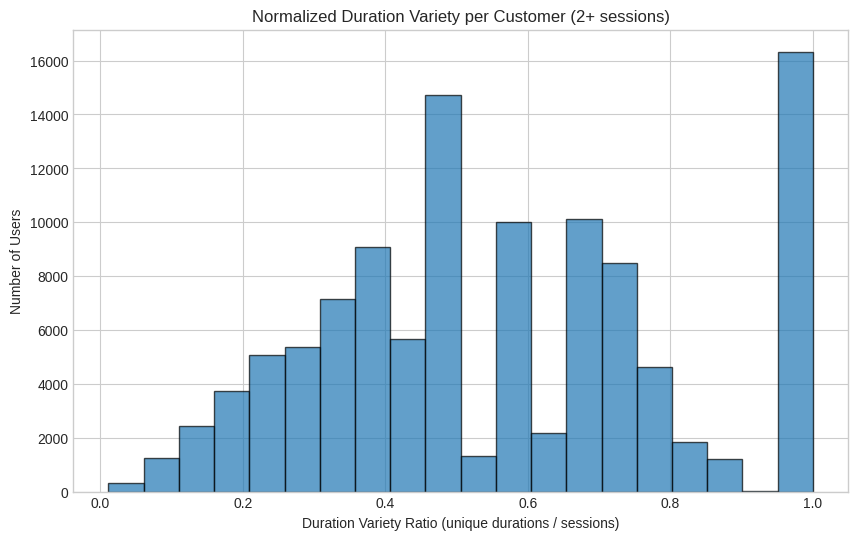

In [31]:
# Now only the variety ratio
plt.figure(figsize=(10, 6))
plt.hist(user_duration_variety['variety_ratio'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Duration Variety Ratio (unique durations / sessions)')
plt.ylabel('Number of Users')
plt.title('Normalized Duration Variety per Customer (2+ sessions)')
plt.show()

**Diverse behavior. Some users do not change their duration (veriary=1). Other tend to use multiple price tiers.**

### Repeat Purchase Patterns

Same as before but with comb (duration/density)

Affects how we count interactions (binary vs. frequency).

In [32]:
df.head()

,customer,time,duration,actions_in_session,density,orig_duration,orig_density,comb,duration_int
0,13996117415,2021-02-12 02:56:35+00:00,1.0,7,7.0,1.25,5.60,"(1.0, 7.0)",1
1,12734718207,2021-01-22 12:08:23+00:00,30.0,181,6.0,30.34,5.97,"(30.0, 6.0)",30
2,14125989847,2021-01-30 21:29:55+00:00,6.0,50,8.0,5.98,8.36,"(6.0, 8.0)",6
3,10042558183,2021-02-04 15:49:13+00:00,11.0,50,5.0,10.86,4.60,"(11.0, 5.0)",11
4,13728624671,2021-01-26 19:33:57+00:00,3.0,12,4.0,2.96,4.05,"(3.0, 4.0)",3


In [33]:
# Filter to users with 2+ transactions
user_comb_variety = df.groupby('customer').agg(
    n_transactions=('comb', 'count'),
    n_unique_combs=('comb', 'nunique')
)
user_comb_variety = user_comb_variety[user_comb_variety['n_transactions'] >= 2]
user_comb_variety['variety_ratio'] = user_comb_variety['n_unique_combs'] / user_comb_variety['n_transactions']

In [34]:
user_comb_variety.head()

,n_transactions,n_unique_combs,variety_ratio
customer,,,
38763,5,5,1.000000
102195,7,6,0.857143
120491,22,14,0.636364
228103,5,5,1.000000
347903,4,4,1.000000


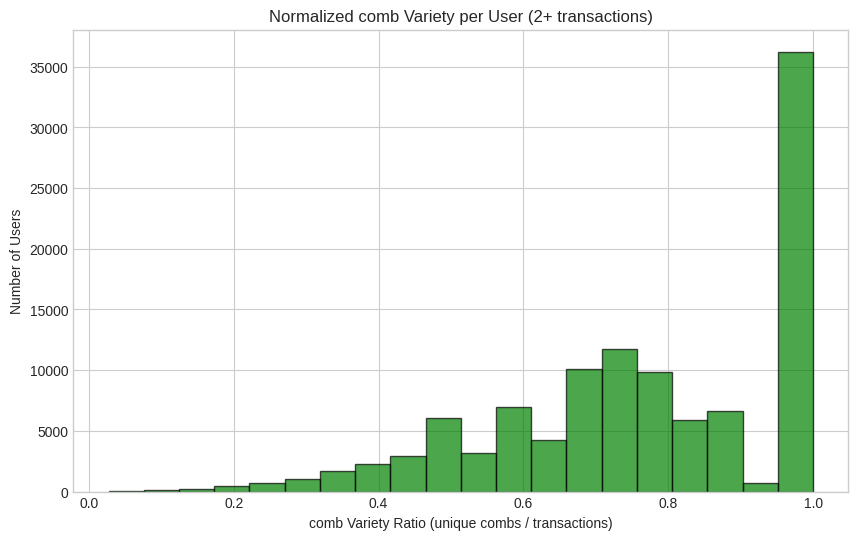

In [35]:
# Plot variety ratio of combs
plt.figure(figsize=(10, 6))
plt.hist(user_comb_variety['variety_ratio'], bins=20, edgecolor='black', alpha=0.7, color='g')
plt.xlabel('comb Variety Ratio (unique combs / transactions)')
plt.ylabel('Number of Users')
plt.title('Normalized comb Variety per User (2+ transactions)')
plt.show()

**We see that we can and need to use the interaction count (frequency).**

### Co-purchase Analysis

Which combs are bought by the same users?

Foundation for item-item collaborative filtering.

In [36]:
# Which durations are co-purchased by the same users?
from itertools import combinations

# Get durations purchased by each user
user_durations = df.groupby('customer')['duration'].apply(set)

# Count co-occurrences
duration_pairs = Counter()
for durations in user_durations:
    if len(durations) > 1:
        for pair in combinations(sorted(durations), 2):
            duration_pairs[pair] += 1

print("=== Most Common Duration Co-purchases ===")
if duration_pairs:
    for pair, count in duration_pairs.most_common(10):
        print(f"  {pair[0]} - {pair[1]}: {count} customers")
else:
    print("No co-purchases found (all customers use only one duration tier).")

=== Most Common Duration Co-purchases ===
  2.0 - 3.0: 38101 customers
  1.0 - 2.0: 31372 customers
  10.0 - 11.0: 19039 customers
  1.0 - 3.0: 17610 customers
  2.0 - 5.0: 15297 customers
  2.0 - 6.0: 15215 customers
  5.0 - 6.0: 14260 customers
  2.0 - 10.0: 13961 customers
  2.0 - 11.0: 13532 customers
  3.0 - 5.0: 12644 customers


In [37]:
# Create co-purchase matrix for durations
unique_durations = sorted(df['duration'].unique())

copurchase_matrix = pd.DataFrame(0, index=unique_durations, columns=unique_durations)

for durations in user_durations:
    if len(durations) > 1:
        for p1, p2 in combinations(durations, 2):
            copurchase_matrix.loc[p1, p2] += 1
            copurchase_matrix.loc[p2, p1] += 1

# Diagonal = users who bought that duration
duration_user_counts = df.groupby('duration')['customer'].nunique()
for p in unique_durations:
    copurchase_matrix.loc[p, p] = duration_user_counts.get(p, 0)

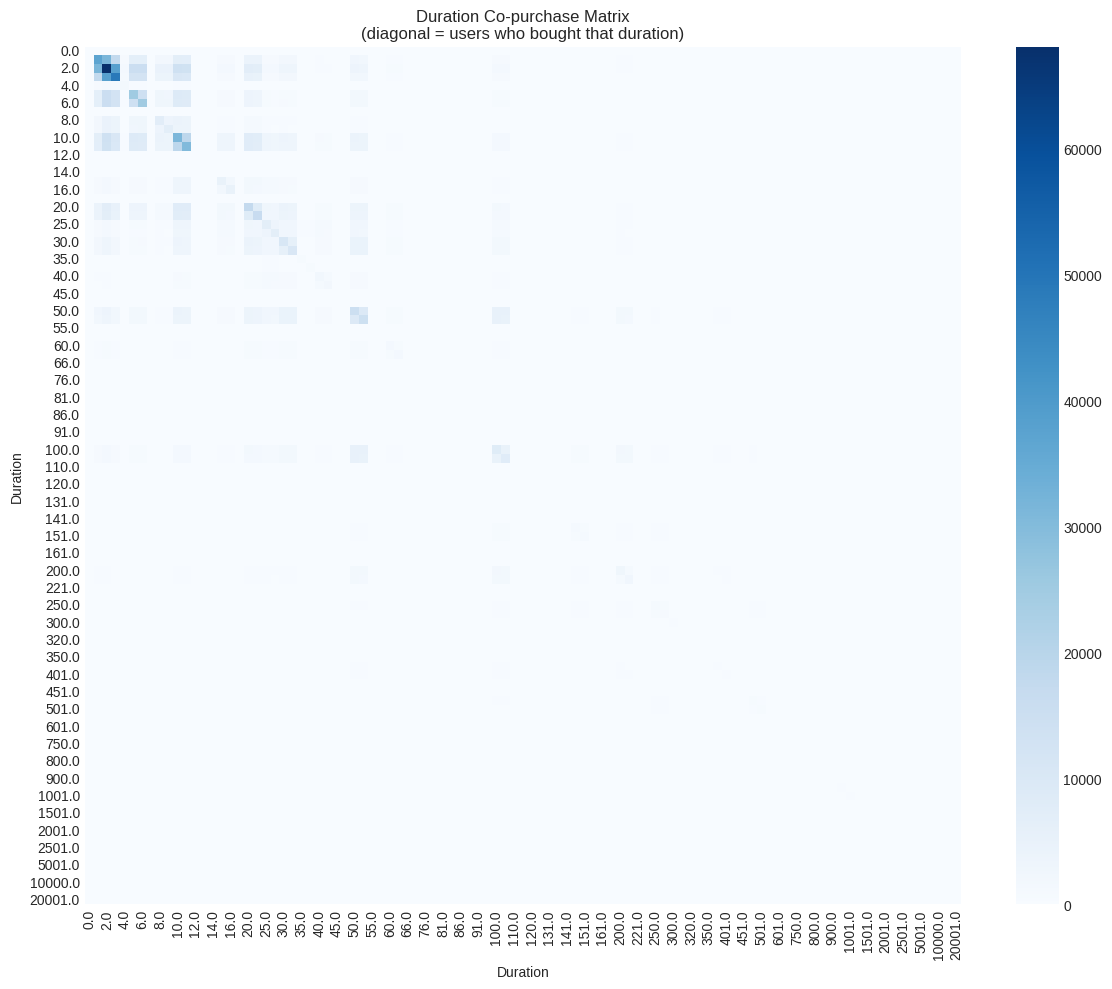

In [38]:
plt.figure(figsize=(12, 10))
sns.heatmap(copurchase_matrix, annot=False, fmt='d', cmap='Blues')
plt.title('Duration Co-purchase Matrix\n(diagonal = users who bought that duration)')
plt.xlabel('Duration')
plt.ylabel('Duration')
plt.tight_layout()
plt.show()

## Key Findings

| Finding | Value | Implication |
|---------|-------|-------------|
| Customer-duration matrix density | 12.47% | Strong collaborative signal at duration level |
| Customer-comb matrix density | 2.06% | Sparser signal at comb level, but acceptable |
| Repeat customer-duration combinations | 60% | Users repeat durations often |
| Duration concentration | 8 durations = ~90% of transactions | Heavy-tailed distribution |
| Density variance within duration | High (see boxplot) | comb-level differentiation matters |
| User duration variety | Bimodal distribution | Two archetypes: loyal vs. explorer |

## Design Principles

#### 1. optimize both duration and combs
I will model user preferences as a combination of two components:
- **Duration**: Learned from the user-duration matrix
- **Combination**: Learned from the user-comb matrix
- **λ**: Tunable weight balancing the two signals
- (It is like a category / item components, where duration is the category and comb is the item)

#### 2. Implicit feedback handling
- Use `implicit` library with ALS optimization
- Interaction weights: log-dampened frequency `w = 1 + log(1 + count)` to prevent the dominance of heavy users.

#### 3. Evaluation strategy
- **Temporal split**: Train on Jan 15 – Feb 9, Test on Feb 9 – Feb 15
- **Metrics**: Precision@6, Recall@6, NDCG@6
- Use adaptive-k evaluation: for each user: k = min(actual_purchases, 6). For example, if a test user has only 2 combs, k for evaluation is 2.


#### 4. Assumptions

1. All combs can be recommended to any user at any time, including already purchased combs (no availability constraints)
2. Users choose based on both duration AND value (actions/density)
3. No external factors affecting density availability (for example if a user-tier is exposed only to certain combs, etc.)

---

## Process Data

In [21]:
# Sort by time for temporal split, so that the train/test and train/eval are built correctly
df = df.sort_values('time').reset_index(drop=True)

In [22]:
# Determine split date (80/20 temporal split)
min_date = df['time'].min()
max_date = df['time'].max()
date_range = (max_date - min_date).days

# Split at 80% of the time period
split_date = min_date + pd.Timedelta(days=int(date_range * 0.8))
print(split_date)

2021-02-08 00:00:04+00:00


In [23]:
min_date.date()

datetime.date(2021, 1, 15)

In [24]:
max_date.date()

datetime.date(2021, 2, 15)

In [25]:
print(f"Train period: {min_date.date()} to {split_date.date()}")
print(f"Test period: {split_date.date()} to {max_date.date()}")

Train period: 2021-01-15 to 2021-02-08
Test period: 2021-02-08 to 2021-02-15


In [26]:
train_df = df[df['time'] < split_date].copy()
test_df = df[df['time'] >= split_date].copy()

print(len(train_df))
print(len(test_df))

743388
256612


In [27]:

# Create user mapping: user_id -> user_index
unique_users_train = train_df['customer'].unique()
user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users_train)}
idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}

# Create duration mapping: duration -> duration_index
unique_durations_train  = sorted(train_df['duration'].unique())
duration_to_idx = {duration: idx for idx, duration in enumerate(unique_durations_train)}
idx_to_duration = {idx: duration for duration, idx in duration_to_idx.items()}

# Create comb mapping: comb -> comb_index
unique_combs_train  = train_df['comb'].unique()
comb_to_idx = {comb: idx for idx, comb in enumerate(unique_combs_train)}
idx_to_comb = {idx: comb for comb, idx in comb_to_idx.items()}

# Create comb -> duration mapping for hierarchical scoring
comb_to_duration = {}
for comb in unique_combs_train:
    # Extract duration from comb tuple (duration, density)
    duration = comb[0]
    comb_idx = comb_to_idx[comb]
    duration_idx = duration_to_idx[duration]
    comb_to_duration[comb_idx] = duration_idx

In [28]:
print(list(comb_to_duration.items())[:10])

[(0, 2), (1, 11), (2, 20), (3, 5), (4, 1), (5, 2), (6, 3), (7, 19), (8, 1), (9, 11)]


In [29]:
# Set global dimensions from TRAINING
n_users_global = len(user_to_idx)
n_durations_global = len(duration_to_idx)
n_combs_global = len(comb_to_idx)

print(f"Training set entities:")
print(f"  Users: {n_users_global:,}")
print(f"  Duration: {n_durations_global:,}")
print(f"  combs: {n_combs_global:,}")

Training set entities:
  Users: 110,493
  Duration: 93
  combs: 363


In [30]:
# For train: all entities exist in mappings
train_df['user_idx'] = train_df['customer'].map(user_to_idx)
train_df['duration_idx'] = train_df['duration'].map(duration_to_idx)
train_df['comb_idx'] = train_df['comb'].map(comb_to_idx)

# For test: map only; some may be NaN (cold-start items)
test_df['user_idx'] = test_df['customer'].map(user_to_idx)
test_df['duration_idx'] = test_df['duration'].map(duration_to_idx)
test_df['comb_idx'] = test_df['comb'].map(comb_to_idx)

In [31]:
train_df.head()

,customer,time,duration,actions_in_session,density,orig_duration,orig_density,comb,user_idx,duration_idx,comb_idx
0,14011197463,2021-01-15 00:00:04+00:00,2.0,16,8.0,2.29,6.99,"(2.0, 8.0)",0,2,0
1,10772389731,2021-01-15 00:00:04+00:00,11.0,76,7.0,10.88,6.99,"(11.0, 7.0)",1,11,1
2,5071077643,2021-01-15 00:00:10+00:00,25.0,181,7.0,25.13,7.20,"(25.0, 7.0)",2,20,2
3,10337050867,2021-01-15 00:00:14+00:00,5.0,38,8.0,5.24,7.25,"(5.0, 8.0)",3,5,3
4,13619923343,2021-01-15 00:00:21+00:00,1.0,6,6.0,1.32,4.55,"(1.0, 6.0)",4,1,4


In [32]:
test_df.head()

,customer,time,duration,actions_in_session,density,orig_duration,orig_density,comb,user_idx,duration_idx,comb_idx
743388,12603576847,2021-02-08 00:00:04+00:00,2.0,12,6.0,2.42,4.96,"(2.0, 6.0)",1791.0,2.0,13.0
743389,12886643327,2021-02-08 00:00:09+00:00,10.0,72,7.0,10.03,7.18,"(10.0, 7.0)",77455.0,10.0,24.0
743390,12771658895,2021-02-08 00:00:09+00:00,1.0,9,9.0,1.13,7.96,"(1.0, 9.0)",88449.0,1.0,8.0
743391,12342210335,2021-02-08 00:00:11+00:00,3.0,13,4.0,2.66,4.89,"(3.0, 4.0)",1923.0,3.0,35.0
743392,10140764483,2021-02-08 00:00:12+00:00,2.0,17,8.0,2.04,8.33,"(2.0, 8.0)",25718.0,2.0,0.0


In [33]:
# Identify evaluation users (in both train and test)
train_users = set(train_df['user_idx'].dropna().unique())
test_users = set(test_df['user_idx'].dropna().unique())
eval_users = train_users & test_users

In [34]:
# Check for cold-start items in test
test_cold_combs = test_df['comb_idx'].isna().sum()
test_cold_durations = test_df['duration_idx'].isna().sum()
print(f"\nCold-start items in test:")
print(f"  combs not in train: {test_cold_combs:,}")
print(f"  Duration not in train: {test_cold_durations:,}")


Cold-start items in test:
  combs not in train: 13
  Duration not in train: 8


**It means that we only evaluate test users that are in the train set (ignoring cold-start).**

In [35]:
def build_interaction_matrix(df, user_col='user_idx', item_col='comb_idx',
                            n_users=None, n_items=None, alpha=1.0):
    """
    Build sparse interaction matrix with log-dampened frequency weighting.
    (weight = 1 + α * log(1 + count)). Rationale: pure frequency over-weights
     power users; log-dampening preserves signal while reducing skew.

    Parameters
    ----------
    df : pd.DataFrame
        Transaction data with user and item indices
    user_col : str
        Column name for user indices
    item_col : str
        Column name for item indices
    n_users : int
        Total number of users (for matrix shape)
    n_items : int
        Total number of items (for matrix shape)
    alpha : float
        Log-dampening parameter (default=1.0)

    Returns
    -------
    csr_matrix
        Sparse user-item interaction matrix
    """
    # Count interactions per (user, item) pair
    interactions = df.groupby([user_col, item_col]).size().reset_index(name='count')

    # Apply log-dampening: weight = 1 + alpha * log(1 + count)
    interactions['weight'] = 1 + alpha * np.log1p(interactions['count'])

    # Determine matrix dimensions
    if n_users is None:
        n_users = df[user_col].max() + 1
    if n_items is None:
        n_items = df[item_col].max() + 1

    # Build sparse matrix
    matrix = csr_matrix(
        (interactions['weight'],
         (interactions[user_col], interactions[item_col])),
        shape=(n_users, n_items),
        dtype=np.float32
    )

    return matrix

In [36]:
# Set alpha parameter for log-dampening
ALPHA = 1.0

In [37]:
# Build User-Duration matrix
R_duration_train = build_interaction_matrix(
    train_df, user_col='user_idx', item_col='duration_idx',
    n_users=n_users_global, n_items=n_durations_global, alpha=ALPHA
)

In [38]:
R_duration_train.shape

(110493, 93)

In [39]:
# Build User-comb matrices
R_comb_train = build_interaction_matrix(
    train_df, user_col='user_idx', item_col='comb_idx',
    n_users=n_users_global, n_items=n_combs_global, alpha=ALPHA
)

In [40]:
R_comb_train.shape

(110493, 363)

## Baseline models

Both a random (random choice of combs), and popular combs (take the most prevalent combs for any user).

In [41]:
class PopularityBaseline:
    """
    Recommend the globally most popular combs.
    """
    def __init__(self):
        self.popular_combs = None

    def fit(self, train_df):
        """Learn popularity from training data."""
        # Count comb occurrences
        comb_counts = train_df['comb_idx'].value_counts()
        # Sort by popularity
        self.popular_combs = comb_counts.index.tolist()
        return self

    def recommend(self, user_idx, k=6):
        """Return top-k most popular combs (same for all users)."""
        return self.popular_combs[:k]


class RandomBaseline:
    """
    Recommend random combs.
    """
    def __init__(self, n_combs, random_state=42):
        self.n_combs = n_combs
        self.rng = np.random.RandomState(random_state)

    def fit(self, train_df):
        """No fitting needed for random baseline."""
        return self

    def recommend(self, user_idx, k=6):
        """Return k random combs."""
        return self.rng.choice(self.n_combs, size=k, replace=False).tolist()


# Train baselines
popularity_baseline = PopularityBaseline().fit(train_df)
random_baseline = RandomBaseline(n_combs=n_combs_global, random_state=42).fit(train_df)

In [42]:
# Check random baseline
random_recs_indeices = random_baseline.recommend(user_idx=0)
print(random_recs_indeices)
random_recs = [idx_to_comb[idx] for idx in random_recs_indeices]
print(random_recs)

[163, 33, 15, 307, 57, 182]
[(100.0, 7.0), (2.0, 7.0), (6.0, 5.0), (36.0, 10.0), (25.0, 6.0), (250.0, 8.0)]


In [43]:
# Check popularity baseline
popularity_recs_indices = popularity_baseline.recommend(user_idx=0)
print(popularity_recs_indices)
popularity_recs = [idx_to_comb[idx] for idx in popularity_recs_indices]
print(popularity_recs)

[13, 5, 6, 0, 35, 9]
[(2.0, 6.0), (2.0, 4.0), (3.0, 5.0), (2.0, 8.0), (3.0, 4.0), (11.0, 5.0)]


## Evaluaiton Setting

In [44]:
def ndcg_at_k(recommended, actual, k):
    """
    Compute NDCG@k for a single user.

    Parameters
    ----------
    recommended : list
        Recommended item indices (ordered by rank)
    actual : set
        Set of actually purchased item indices
    k : int
        Evaluation cutoff

    Returns
    -------
    float
        NDCG@k score
    """
    # DCG: sum of (relevance / log2(rank + 1))
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in actual:
            # Binary relevance: 1 if purchased, 0 otherwise
            dcg += 1.0 / np.log2(i + 2)  # i+2 because rank starts at 1

    # IDCG: best possible DCG (all relevant items at top)
    idcg = 0.0
    n_relevant = min(len(actual), k)
    for i in range(n_relevant):
        idcg += 1.0 / np.log2(i + 2)

    # Avoid division by zero
    if idcg == 0:
        return 0.0

    return dcg / idcg


def evaluate_recommendations(model, test_df, eval_users, model_name="Model", max_k=6):
    """
    Evaluate recommendation model with adaptive-k metrics.

    Parameters
    ----------
    model : object
        Model with recommend(user_idx, k) method
    test_df : pd.DataFrame
        Test transactions
    eval_users : set
        User indices to evaluate
    model_name : str
        Name for display
    max_k : int
        Maximum k for recommendations

    Returns
    -------
    dict
        Dictionary with mean metrics and per-user scores
    """
    # Build ground truth: user -> set of purchased combs
    test_purchases = test_df.groupby('user_idx')['comb_idx'].apply(set).to_dict()

    # Storage for metrics
    precisions = []
    recalls = []
    ndcgs = []

    # Evaluate each user. I can't do it vectotically, because of the individual
    # k per user.
    for user_idx in tqdm(eval_users, desc=f"Evaluating {model_name}"):
        # Get ground truth purchases for this user
        actual = test_purchases.get(user_idx, set())

        # Skip users with no test purchases
        if len(actual) == 0:
            continue

        # Adaptive k: min(actual purchases, max_k)
        k_user = min(len(actual), max_k)

        # Get recommendations
        recommended = model.recommend(user_idx, k=k_user)

        # Calculate hits
        hits = set(recommended) & actual

        # Precision@k: hits / k_user
        precision = len(hits) / k_user

        # Recall@k: hits / total_actual
        recall = len(hits) / len(actual)

        # NDCG@k
        ndcg = ndcg_at_k(recommended, actual, k_user)

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)

    # Aggregate results
    results = {
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'ndcg': np.mean(ndcgs),
        'n_users_evaluated': len(precisions),
        'precision_all': precisions,
        'recall_all': recalls,
        'ndcg_all': ndcgs
    }

    return results

In [45]:
# Popularity baseline
pop_results = evaluate_recommendations(
    popularity_baseline, test_df, eval_users,
    model_name="Popularity", max_k=6
)

Evaluating Popularity: 100%|██████████| 61818/61818 [00:00<00:00, 115191.59it/s]


In [46]:
print("pop_results precision", pop_results['precision'])
print("pop_results recall", pop_results['recall'])
print("pop_results ndcg", pop_results['ndcg'])
print("pop_results, n_users", pop_results['n_users_evaluated'])

pop_results precision 0.12300408726692334
pop_results recall 0.11531641626132959
pop_results ndcg 0.12966839906894487
pop_results, n_users 61818


In [66]:
# Random baseline
random_results = evaluate_recommendations(
    random_baseline, test_df, eval_users,
    model_name="Random", max_k=6
)

Evaluating Random: 100%|██████████| 61818/61818 [00:04<00:00, 14401.90it/s]


In [67]:
random_results.keys()

dict_keys(['precision', 'recall', 'ndcg', 'n_users_evaluated', 'precision_all', 'recall_all', 'ndcg_all'])

In [48]:
print("random_results precision", random_results['precision'])
print("random_results recall", random_results['recall'])
print("random_results ndcg", random_results['ndcg'])
print("random_results, n_users", random_results['n_users_evaluated'])

random_results precision 0.007626419489469086
random_results recall 0.0070473558485502664
random_results ndcg 0.007614245075925275
random_results, n_users 61818


## Recommendation Model

In [49]:
class HierarchicalRecommender:
    """
    Two-stage hierarchical recommender system.
    """

    def __init__(self, factors_duration=64, factors_comb=64,
                 regularization=0.1, iterations=30,
                 lambda_combine=0.5, random_state=42):
        self.factors_duration = factors_duration
        self.factors_comb = factors_comb
        self.regularization = regularization
        self.iterations = iterations
        self.lambda_combine = lambda_combine
        self.random_state = random_state

        # Initialize ALS models
        self.duration_model = AlternatingLeastSquares(
            factors=factors_duration,
            regularization=regularization,
            iterations=iterations,
            random_state=random_state
        )

        self.comb_model = AlternatingLeastSquares(
            factors=factors_comb,
            regularization=regularization,
            iterations=iterations,
            random_state=random_state
        )

        self.comb_to_duration = None
        self.n_combs = None

        # Store the training matrices for scoring
        self.duration_matrix = None
        self.comb_matrix = None

    def fit(self, duration_matrix, comb_matrix, comb_to_duration_mapping):
        """
        Train both ALS models.
        """
        print("Training hierarchical model...")

        # Store matrices and mapping
        self.comb_to_duration = comb_to_duration_mapping
        self.n_combs = comb_matrix.shape[1]
        self.n_durations = duration_matrix.shape[1]
        self.duration_matrix = duration_matrix
        self.comb_matrix = comb_matrix

        # Train duration-level model
        print(f"  Stage 1: Training Duration MF ({self.factors_duration} factors)...")
        self.duration_model.fit(duration_matrix)

        # Train comb-level model
        print(f"  Stage 2: Training comb MF ({self.factors_comb} factors)...")
        self.comb_model.fit(comb_matrix)

        print("Training complete!")
        return self

    def recommend(self, user_idx, k=6):
        """
        Generate top-k comb recommendations for a user.
        """
        # Use the stored dimensions
        n_combs = self.n_combs
        n_durations = self.n_durations

        # Get recommendations from comb model
        comb_recs, comb_scores_raw = self.comb_model.recommend(
            user_idx,
            self.comb_matrix[user_idx],
            N=min(n_combs, k * 10),
            filter_already_liked_items=False,
            recalculate_user=False
        )

        # Create score array for all combs (use matrix dimension, not self.n_combs)
        comb_scores = np.zeros(n_combs)
        comb_scores[comb_recs] = comb_scores_raw

        # Get duration scores
        duration_recs, duration_scores_raw = self.duration_model.recommend(
            user_idx,
            self.duration_matrix[user_idx],
            N=min(n_durations, k * 10),
            filter_already_liked_items=False,
            recalculate_user=False
        )

        # Create score array for all durations (use matrix dimension)
        duration_scores = np.zeros(n_durations)
        duration_scores[duration_recs] = duration_scores_raw

        # Combine scores for all combs
        combined_scores = []
        for comb_idx in range(n_combs):
            if comb_idx in self.comb_to_duration:
                duration_idx = self.comb_to_duration[comb_idx]
                if duration_idx < n_durations:  # Safety check
                    combined_score = (self.lambda_combine * duration_scores[duration_idx] +
                                    (1 - self.lambda_combine) * comb_scores[comb_idx])
                    combined_scores.append((comb_idx, combined_score))

        # Sort and return top-k
        combined_scores.sort(key=lambda x: x[1], reverse=True)
        top_k_combs = [comb_idx for comb_idx, _ in combined_scores[:k]]

        return top_k_combs

## Cross-Validation for Latent Factors (k1, k2)

In [50]:
def create_temporal_val_split(train_df, val_percentage=0.2):
    """
    Create a temporal validation split from training data.

    Parameters
    ----------
    train_df : pd.DataFrame
        Training data
    val_percentage : float
        Percentage of time for validation

    Returns
    -------
    tuple
        (train_fold, val_fold) DataFrames
    """
    min_date = train_df['time'].min()
    max_date = train_df['time'].max()
    date_range = (max_date - min_date).days

    # Split at (1 - val_percentage) of training period
    val_split_date = min_date + pd.Timedelta(days=int(date_range * (1 - val_percentage)))

    train_fold = train_df[train_df['time'] < val_split_date].copy()
    val_fold = train_df[train_df['time'] >= val_split_date].copy()

    return train_fold, val_fold



def cross_validate_factors(train_df, factor_duration_range, factor_comb_range,
                          n_splits=3, val_percentage=0.2,
                          regularization=0.1, iterations=30, lambda_combine=0.5,
                          alpha=1.0):
    """
    Cross-validate different latent factor configurations.

    Parameters
    ----------
    train_df : pd.DataFrame
        Training data
    factor_duration_range : list
        List of duration factor counts to try
    factor_comb_range : list
        List of comb factor counts to try
    n_splits : int
        Number of temporal CV folds
    val_percentage : float
        Percentage for validation in each fold
    regularization : float
        Fixed regularization parameter
    iterations : int
        Fixed iteration count
    lambda_combine : float
        Fixed lambda for combining scores
    alpha : float
        Log-dampening parameter

    Returns
    -------
    pd.DataFrame
        Results with mean and std for each configuration
    """
    results = []

    print("Starting cross-validation...")
    print(f"Factor ranges: Duration={factor_duration_range}, comb={factor_comb_range}")
    print(f"CV folds: {n_splits}, Validation %: {val_percentage*100:.0f}%")
    print("="*60)

    # Try each factor combination
    for k_duration in factor_duration_range:
        for k_comb in factor_comb_range:
            print(f"\nTesting k_duration={k_duration}, k_comb={k_comb}")

            fold_precisions = []
            fold_recalls = []
            fold_ndcgs = []

            # Perform n_splits temporal folds
            for split_idx in range(n_splits):
                # Shift validation window for each split
                val_pct = val_percentage + (split_idx * 0.05)
                train_fold, val_fold = create_temporal_val_split(train_df, val_pct)

                # Build matrices for this fold
                R_duration_fold = build_interaction_matrix(
                    train_fold, 'user_idx', 'duration_idx',
                    n_users=n_users_global, n_items=n_durations_global, alpha=alpha
                )
                R_comb_fold = build_interaction_matrix(
                    train_fold, 'user_idx', 'comb_idx',
                    n_users=n_users_global, n_items=n_combs_global, alpha=alpha
                )

                # Train model (now stores matrices internally)
                model = HierarchicalRecommender(
                    factors_duration=k_duration,
                    factors_comb=k_comb,
                    regularization=regularization,
                    iterations=iterations,
                    lambda_combine=lambda_combine,
                    random_state=42 + split_idx
                )
                model.fit(R_duration_fold, R_comb_fold, comb_to_duration)

                # Get users that appear in train_fold (model was trained on them)
                train_fold_user_set = set(train_fold['user_idx'].unique())

                # Filter val_fold to only include these users
                val_fold_filtered = val_fold[val_fold['user_idx'].isin(train_fold_user_set)]

                # Evaluation users: only those in both train_fold and val_fold
                fold_eval_users = set(val_fold_filtered['user_idx'].unique())

                # Skip if no users to evaluate
                if len(fold_eval_users) == 0:
                    print(f"  WARNING: No overlapping users in fold {split_idx+1}, skipping")
                    continue

                # Evaluate on validation fold
                val_results = evaluate_recommendations(
                    model, val_fold_filtered, fold_eval_users,
                    model_name=f"Fold {split_idx+1}", max_k=6
                )

                fold_precisions.append(val_results['precision'])
                fold_recalls.append(val_results['recall'])
                fold_ndcgs.append(val_results['ndcg'])

                print(f"  Fold {split_idx+1}: P={val_results['precision']:.4f}, "
                      f"R={val_results['recall']:.4f}, NDCG={val_results['ndcg']:.4f}")

            # Skip if no successful folds
            if len(fold_precisions) == 0:
                print(f"  WARNING: No successful folds for k_price={k_duration}, k_comb={k_comb}")
                continue

            # Aggregate across folds
            results.append({
                'k_duration': k_duration,
                'k_comb': k_comb,
                'mean_precision': np.mean(fold_precisions),
                'std_precision': np.std(fold_precisions),
                'mean_recall': np.mean(fold_recalls),
                'std_recall': np.std(fold_recalls),
                'mean_ndcg': np.mean(fold_ndcgs),
                'std_ndcg': np.std(fold_ndcgs)
            })

            print(f"  Average: P={results[-1]['mean_precision']:.4f}±{results[-1]['std_precision']:.4f}, "
                  f"R={results[-1]['mean_recall']:.4f}±{results[-1]['std_recall']:.4f}, "
                  f"NDCG={results[-1]['mean_ndcg']:.4f}±{results[-1]['std_ndcg']:.4f}")

    return pd.DataFrame(results)

In [52]:
# Run cross-validation to find optimal k_duration and k_comb

FACTOR_DURATION_RANGE = [16, 32, 64, 128]
FACTOR_comb_RANGE = [16, 32, 64, 128]

cv_results = cross_validate_factors(
    train_df,
    factor_duration_range=FACTOR_DURATION_RANGE,
    factor_comb_range=FACTOR_comb_RANGE,
    n_splits=3,
    val_percentage=0.2,
    regularization=0.1,
    iterations=30,
    lambda_combine=0.5,
    alpha=ALPHA
)

# Display results sorted by NDCG
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS (sorted by NDCG)")
print("="*60)
print(cv_results.sort_values('mean_ndcg', ascending=False).to_string(index=False))

# Select best configuration (I took the NDCG as the leading metric)
best_config = cv_results.loc[cv_results['mean_ndcg'].idxmax()]
best_k_duration = int(best_config['k_duration'])
best_k_comb = int(best_config['k_comb'])

print(f"\nBest configuration: k_duration={best_k_duration}, k_comb={best_k_comb}")
print(f"  NDCG: {best_config['mean_ndcg']:.4f} ± {best_config['std_ndcg']:.4f}")

Starting cross-validation...
Factor ranges: Duration=[16, 32, 64, 128], comb=[16, 32, 64, 128]
CV folds: 3, Validation %: 20%

Testing k_duration=16, k_comb=16
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1544.44it/s]


  Fold 1: P=0.1943, R=0.1879, NDCG=0.2019
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1515.40it/s]


  Fold 2: P=0.1982, R=0.1904, NDCG=0.2065
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1584.98it/s]


  Fold 3: P=0.2014, R=0.1922, NDCG=0.2112
  Average: P=0.1980±0.0029, R=0.1902±0.0018, NDCG=0.2065±0.0038

Testing k_duration=16, k_comb=32
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1533.45it/s]


  Fold 1: P=0.1908, R=0.1847, NDCG=0.1973
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1532.52it/s]


  Fold 2: P=0.1929, R=0.1854, NDCG=0.2002
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1556.29it/s]


  Fold 3: P=0.1983, R=0.1893, NDCG=0.2068
  Average: P=0.1940±0.0031, R=0.1865±0.0021, NDCG=0.2014±0.0039

Testing k_duration=16, k_comb=64
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1542.74it/s]


  Fold 1: P=0.1828, R=0.1770, NDCG=0.1888
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:34<00:00, 1602.75it/s]


  Fold 2: P=0.1867, R=0.1795, NDCG=0.1943
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1532.22it/s]


  Fold 3: P=0.1897, R=0.1812, NDCG=0.1980
  Average: P=0.1864±0.0028, R=0.1792±0.0017, NDCG=0.1937±0.0038

Testing k_duration=16, k_comb=128
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1569.37it/s]


  Fold 1: P=0.1792, R=0.1734, NDCG=0.1857
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:37<00:00, 1501.80it/s]


  Fold 2: P=0.1833, R=0.1761, NDCG=0.1913
Training hierarchical model...
  Stage 1: Training Duration MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1501.11it/s]


  Fold 3: P=0.1853, R=0.1769, NDCG=0.1940
  Average: P=0.1826±0.0025, R=0.1754±0.0015, NDCG=0.1903±0.0034

Testing k_duration=32, k_comb=16
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1521.53it/s]


  Fold 1: P=0.1964, R=0.1901, NDCG=0.2039
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1527.69it/s]


  Fold 2: P=0.2000, R=0.1922, NDCG=0.2083
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1571.03it/s]


  Fold 3: P=0.2036, R=0.1943, NDCG=0.2130
  Average: P=0.2000±0.0029, R=0.1922±0.0017, NDCG=0.2084±0.0037

Testing k_duration=32, k_comb=32
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1571.62it/s]


  Fold 1: P=0.1933, R=0.1871, NDCG=0.1997
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1529.65it/s]


  Fold 2: P=0.1952, R=0.1876, NDCG=0.2025
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1598.18it/s]


  Fold 3: P=0.1997, R=0.1907, NDCG=0.2081
  Average: P=0.1961±0.0027, R=0.1885±0.0016, NDCG=0.2034±0.0035

Testing k_duration=32, k_comb=64
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1586.63it/s]


  Fold 1: P=0.1834, R=0.1775, NDCG=0.1897
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1518.33it/s]


  Fold 2: P=0.1868, R=0.1796, NDCG=0.1946
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1515.65it/s]


  Fold 3: P=0.1903, R=0.1817, NDCG=0.1987
  Average: P=0.1868±0.0028, R=0.1796±0.0017, NDCG=0.1944±0.0037

Testing k_duration=32, k_comb=128
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:35<00:00, 1476.15it/s]


  Fold 1: P=0.1818, R=0.1759, NDCG=0.1886
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:37<00:00, 1488.67it/s]


  Fold 2: P=0.1851, R=0.1778, NDCG=0.1936
Training hierarchical model...
  Stage 1: Training Duration MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1516.03it/s]


  Fold 3: P=0.1873, R=0.1788, NDCG=0.1968
  Average: P=0.1847±0.0023, R=0.1775±0.0012, NDCG=0.1930±0.0034

Testing k_duration=64, k_comb=16
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1591.08it/s]


  Fold 1: P=0.1966, R=0.1902, NDCG=0.2040
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:34<00:00, 1592.88it/s]


  Fold 2: P=0.2002, R=0.1923, NDCG=0.2083
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1549.07it/s]


  Fold 3: P=0.2038, R=0.1945, NDCG=0.2132
  Average: P=0.2002±0.0029, R=0.1923±0.0017, NDCG=0.2085±0.0038

Testing k_duration=64, k_comb=32
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1519.50it/s]


  Fold 1: P=0.1932, R=0.1871, NDCG=0.1996
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1533.56it/s]


  Fold 2: P=0.1954, R=0.1878, NDCG=0.2026
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:35<00:00, 1600.81it/s]


  Fold 3: P=0.2001, R=0.1911, NDCG=0.2085
  Average: P=0.1962±0.0029, R=0.1886±0.0017, NDCG=0.2035±0.0037

Testing k_duration=64, k_comb=64
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1554.85it/s]


  Fold 1: P=0.1837, R=0.1779, NDCG=0.1899
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:37<00:00, 1499.09it/s]


  Fold 2: P=0.1868, R=0.1796, NDCG=0.1945
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1517.20it/s]


  Fold 3: P=0.1905, R=0.1819, NDCG=0.1989
  Average: P=0.1870±0.0027, R=0.1798±0.0017, NDCG=0.1944±0.0037

Testing k_duration=64, k_comb=128
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1547.23it/s]


  Fold 1: P=0.1828, R=0.1769, NDCG=0.1898
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1520.02it/s]


  Fold 2: P=0.1863, R=0.1790, NDCG=0.1945
Training hierarchical model...
  Stage 1: Training Duration MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1488.19it/s]


  Fold 3: P=0.1881, R=0.1795, NDCG=0.1974
  Average: P=0.1857±0.0022, R=0.1785±0.0011, NDCG=0.1939±0.0031

Testing k_duration=128, k_comb=16
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1580.30it/s]


  Fold 1: P=0.1966, R=0.1902, NDCG=0.2041
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:35<00:00, 1564.36it/s]


  Fold 2: P=0.2002, R=0.1924, NDCG=0.2084
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1536.37it/s]


  Fold 3: P=0.2038, R=0.1945, NDCG=0.2133
  Average: P=0.2002±0.0029, R=0.1924±0.0018, NDCG=0.2086±0.0038

Testing k_duration=128, k_comb=32
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1555.40it/s]


  Fold 1: P=0.1935, R=0.1873, NDCG=0.1999
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:35<00:00, 1583.79it/s]


  Fold 2: P=0.1955, R=0.1879, NDCG=0.2027
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (32 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1548.62it/s]


  Fold 3: P=0.2002, R=0.1911, NDCG=0.2086
  Average: P=0.1964±0.0028, R=0.1888±0.0017, NDCG=0.2037±0.0036

Testing k_duration=128, k_comb=64
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1559.50it/s]


  Fold 1: P=0.1838, R=0.1780, NDCG=0.1902
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1529.18it/s]


  Fold 2: P=0.1870, R=0.1798, NDCG=0.1949
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (64 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1506.34it/s]


  Fold 3: P=0.1909, R=0.1823, NDCG=0.1994
  Average: P=0.1873±0.0029, R=0.1800±0.0018, NDCG=0.1948±0.0037

Testing k_duration=128, k_comb=128
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1528.45it/s]


  Fold 1: P=0.1829, R=0.1770, NDCG=0.1900
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1542.11it/s]


  Fold 2: P=0.1863, R=0.1790, NDCG=0.1947
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1487.36it/s]


  Fold 3: P=0.1885, R=0.1800, NDCG=0.1980
  Average: P=0.1859±0.0023, R=0.1786±0.0013, NDCG=0.1942±0.0033

CROSS-VALIDATION RESULTS (sorted by NDCG)
 k_duration  k_comb  mean_precision  std_precision  mean_recall  std_recall  mean_ndcg  std_ndcg
        128      16        0.200228       0.002941     0.192381    0.001758   0.208571  0.003780
         64      16        0.200182       0.002926     0.192339    0.001742   0.208513  0.003760
         32      16        0.200026       0.002915     0.192188    0.001728   0.208396  0.003734
         16      16        0.197963       0.002907     0.190170    0.001753   0.206529  0.003792
        128      32        0.196366       0.002797     0.188769    0.001694   0.203727  0.003621
         64      32        0.196243       0.002850     0.188647    0.001738   0.203550  0.003694
         32      32        0.196073       0.002702     0.188488    0.001599   0.203442  0.003478
         16      32        0.193997       0.003139     0.186454    0.002058

## Parameter Tuning

Now that I have optimal k_duration and k_comb I tune the rest of the parameters (random search).

In [53]:
def random_search_hyperparameters(
    train_df, k_duration, k_comb,
    n_trials=20,
    param_ranges=None,
    n_splits=3,
    val_percentage=0.2,
    random_state=42
):
    """
    Random search over multiple hyperparameters.

    Parameters
    ----------
    train_df : pd.DataFrame
        Training data
    k_duration, k_comb : int
        Fixed latent factor dimensions
    n_trials : int
        Number of random configurations to try
    param_ranges : dict
        Dictionary with ranges for each parameter:
        {
            'lambda': (min, max),           # Uniform sampling
            'alpha': (min, max, 'log'),     # Log-uniform sampling
            'regularization': (min, max, 'log'),
            'iterations': (min, max, 'int') # Integer sampling
        }
    n_splits : int
        Number of CV folds
    val_percentage : float
        Validation percentage
    random_state : int
        Random seed

    Returns
    -------
    results_df : pd.DataFrame
        All trials with their configurations and scores
    best_config : dict
        Best hyperparameter configuration found
    """
    np.random.seed(random_state)

    # Default parameter ranges if not provided
    if param_ranges is None:
        param_ranges = {
            'lambda': (0.0, 1.0),
            'alpha': (0.5, 5.0, 'log'),
            'regularization': (0.001, 1.0, 'log'),
            'iterations': (15, 50, 'int')
        }

    print("="*70)
    print(f"RANDOM HYPERPARAMETER SEARCH: {n_trials} trials")
    print("="*70)
    print(f"Fixed: k_duration={k_duration}, k_comb={k_comb}")
    print(f"Tuning ranges:")
    for param, range_spec in param_ranges.items():
        if len(range_spec) == 2:
            print(f"  {param}: [{range_spec[0]:.4f}, {range_spec[1]:.4f}] (uniform)")
        elif range_spec[2] == 'log':
            print(f"  {param}: [{range_spec[0]:.4f}, {range_spec[1]:.4f}] (log-uniform)")
        elif range_spec[2] == 'int':
            print(f"  {param}: [{int(range_spec[0])}, {int(range_spec[1])}] (integer)")
    print("="*70)

    results = []
    best_ndcg = -np.inf
    best_config = None

    for trial_idx in range(n_trials):
        # Sample random configuration
        config = {}
        for param, range_spec in param_ranges.items():
            if len(range_spec) == 2:
                # Uniform sampling
                config[param] = np.random.uniform(range_spec[0], range_spec[1])
            elif range_spec[2] == 'log':
                # Log-uniform sampling
                log_min = np.log10(range_spec[0])
                log_max = np.log10(range_spec[1])
                config[param] = 10 ** np.random.uniform(log_min, log_max)
            elif range_spec[2] == 'int':
                # Integer sampling
                config[param] = np.random.randint(range_spec[0], range_spec[1] + 1)

        print(f"\n{'='*70}")
        print(f"Trial {trial_idx+1}/{n_trials}")
        print(f"Config: lambda={config['lambda']:.4f}, alpha={config['alpha']:.4f}, "
              f"reg={config['regularization']:.4f}, iter={config['iterations']}")
        print(f"{'='*70}")

        fold_precisions = []
        fold_recalls = []
        fold_ndcgs = []

        # Cross-validation
        for split_idx in range(n_splits):
            val_pct = val_percentage + (split_idx * 0.05)
            train_fold, val_fold = create_temporal_val_split(train_df, val_pct)

            # Build matrices with sampled alpha
            R_duration_fold = build_interaction_matrix(
                train_fold, 'user_idx', 'duration_idx',
                n_users=n_users_global, n_items=n_durations_global,
                alpha=config['alpha']
            )
            R_comb_fold = build_interaction_matrix(
                train_fold, 'user_idx', 'comb_idx',
                n_users=n_users_global, n_items=n_combs_global,
                alpha=config['alpha']
            )

            # Train with sampled hyperparameters
            model = HierarchicalRecommender(
                factors_duration=k_duration,
                factors_comb=k_comb,
                regularization=config['regularization'],
                iterations=int(config['iterations']),
                lambda_combine=config['lambda'],
                random_state=42 + split_idx
            )
            model.fit(R_duration_fold, R_comb_fold, comb_to_duration)

            # Evaluate
            fold_train_users = set(train_fold['user_idx'].unique())
            fold_val_users = set(val_fold['user_idx'].unique())
            fold_eval_users = fold_train_users & fold_val_users

            if len(fold_eval_users) == 0:
                print(f"  WARNING: No overlapping users in fold {split_idx+1}, skipping")
                continue

            val_results = evaluate_recommendations(
                model, val_fold, fold_eval_users,
                model_name=f"Fold {split_idx+1}", max_k=6
            )

            fold_precisions.append(val_results['precision'])
            fold_recalls.append(val_results['recall'])
            fold_ndcgs.append(val_results['ndcg'])

            print(f"  Fold {split_idx+1}: P={val_results['precision']:.4f}, "
                  f"R={val_results['recall']:.4f}, NDCG={val_results['ndcg']:.4f}")

        # Skip if no successful folds
        if len(fold_ndcgs) == 0:
            print(f"  WARNING: No successful folds for this configuration")
            continue

        # Aggregate results
        mean_precision = np.mean(fold_precisions)
        mean_recall = np.mean(fold_recalls)
        mean_ndcg = np.mean(fold_ndcgs)
        std_ndcg = np.std(fold_ndcgs)

        results.append({
            'trial': trial_idx + 1,
            'lambda': config['lambda'],
            'alpha': config['alpha'],
            'regularization': config['regularization'],
            'iterations': int(config['iterations']),
            'mean_precision': mean_precision,
            'std_precision': np.std(fold_precisions),
            'mean_recall': mean_recall,
            'std_recall': np.std(fold_recalls),
            'mean_ndcg': mean_ndcg,
            'std_ndcg': std_ndcg
        })

        # Track best
        if mean_ndcg > best_ndcg:
            best_ndcg = mean_ndcg
            best_config = config.copy()
            print(f"\n  *** NEW BEST! NDCG={mean_ndcg:.4f} ± {std_ndcg:.4f} ***")
        else:
            print(f"\n  Average: P={mean_precision:.4f}, R={mean_recall:.4f}, "
                  f"NDCG={mean_ndcg:.4f} ± {std_ndcg:.4f}")

    results_df = pd.DataFrame(results)

    print("\n" + "="*70)
    print("RANDOM SEARCH COMPLETE")
    print("="*70)
    print(f"Best configuration found:")
    print(f"  lambda: {best_config['lambda']:.4f}")
    print(f"  alpha: {best_config['alpha']:.4f}")
    print(f"  regularization: {best_config['regularization']:.4f}")
    print(f"  iterations: {int(best_config['iterations'])}")
    print(f"  NDCG: {best_ndcg:.4f}")

    return results_df, best_config

In [54]:
# Define parameter ranges (optional, uses defaults if not provided)
param_ranges = {
    'lambda': (0.0, 1.0),              # Weight for combining price/comb scores
    'alpha': (0.5, 5.0, 'log'),        # Confidence weighting for implicit feedback
    'regularization': (0.01, 0.5, 'log'),  # L2 regularization
    'iterations': (20, 40, 'int')      # ALS iterations
}
# (of course I can have different n iterations for price and combs, but simplifying)

# Run random search
random_results, best_config = random_search_hyperparameters(
    train_df,
    k_duration=best_k_duration,
    k_comb=best_k_comb,
    n_trials=25,  # Try 25 random configurations
    param_ranges=param_ranges,
    n_splits=3,
    val_percentage=0.2,
    random_state=42
)

# Display results
print("\n" + "="*70)
print("TOP 10 CONFIGURATIONS (sorted by NDCG)")
print("="*70)
print(random_results.sort_values('mean_ndcg', ascending=False).head(10).to_string(index=False))

# Use best config for final model
print(f"\nFinal hyperparameters:")
print(f"  lambda: {best_config['lambda']:.4f}")
print(f"  alpha: {best_config['alpha']:.4f}")
print(f"  regularization: {best_config['regularization']:.4f}")
print(f"  iterations: {int(best_config['iterations'])}")

RANDOM HYPERPARAMETER SEARCH: 25 trials
Fixed: k_duration=128, k_comb=16
Tuning ranges:
  lambda: [0.0000, 1.0000] (uniform)
  alpha: [0.5000, 5.0000] (log-uniform)
  regularization: [0.0100, 0.5000] (log-uniform)
  iterations: [20, 40] (integer)

Trial 1/25
Config: lambda=0.3745, alpha=4.4636, reg=0.1752, iter=40
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:32<00:00, 1623.20it/s]


  Fold 1: P=0.2041, R=0.1976, NDCG=0.2118
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1532.31it/s]


  Fold 2: P=0.2076, R=0.1996, NDCG=0.2158
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:35<00:00, 1611.69it/s]


  Fold 3: P=0.2128, R=0.2032, NDCG=0.2219

  *** NEW BEST! NDCG=0.2165 ± 0.0041 ***

Trial 2/25
Config: lambda=0.1560, alpha=0.7161, reg=0.0126, iter=40
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1536.16it/s]


  Fold 1: P=0.1993, R=0.1928, NDCG=0.2059
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:34<00:00, 1600.47it/s]


  Fold 2: P=0.2029, R=0.1950, NDCG=0.2100
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1537.88it/s]


  Fold 3: P=0.2067, R=0.1973, NDCG=0.2148

  Average: P=0.2030, R=0.1951, NDCG=0.2102 ± 0.0036

Trial 3/25
Config: lambda=0.6011, alpha=2.5530, reg=0.0108, iter=21
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:32<00:00, 1607.38it/s]


  Fold 1: P=0.2009, R=0.1944, NDCG=0.2084
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:35<00:00, 1580.80it/s]


  Fold 2: P=0.2052, R=0.1972, NDCG=0.2134
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1528.03it/s]


  Fold 3: P=0.2100, R=0.2005, NDCG=0.2188

  Average: P=0.2053, R=0.1974, NDCG=0.2135 ± 0.0043

Trial 4/25
Config: lambda=0.7220, alpha=4.3403, reg=0.0100, iter=40
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1560.47it/s]


  Fold 1: P=0.2043, R=0.1977, NDCG=0.2120
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:35<00:00, 1561.66it/s]


  Fold 2: P=0.2079, R=0.1999, NDCG=0.2162
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/40 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1547.48it/s]


  Fold 3: P=0.2123, R=0.2028, NDCG=0.2216

  *** NEW BEST! NDCG=0.2166 ± 0.0040 ***

Trial 5/25
Config: lambda=0.6175, alpha=2.0447, reg=0.0103, iter=36
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/36 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/36 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1542.16it/s]


  Fold 1: P=0.1999, R=0.1935, NDCG=0.2073
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/36 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/36 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1523.53it/s]


  Fold 2: P=0.2034, R=0.1955, NDCG=0.2117
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/36 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/36 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1585.57it/s]


  Fold 3: P=0.2079, R=0.1984, NDCG=0.2172

  Average: P=0.2037, R=0.1958, NDCG=0.2121 ± 0.0040

Trial 6/25
Config: lambda=0.5248, alpha=1.2555, reg=0.0120, iter=35
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/35 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/35 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1598.11it/s]


  Fold 1: P=0.1979, R=0.1915, NDCG=0.2052
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/35 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/35 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:34<00:00, 1602.85it/s]


  Fold 2: P=0.2010, R=0.1931, NDCG=0.2093
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/35 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/35 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:35<00:00, 1602.32it/s]


  Fold 3: P=0.2048, R=0.1955, NDCG=0.2143

  Average: P=0.2012, R=0.1934, NDCG=0.2096 ± 0.0037

Trial 7/25
Config: lambda=0.2328, alpha=0.6160, reg=0.1124, iter=31
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/31 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/31 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1586.03it/s]


  Fold 1: P=0.1976, R=0.1912, NDCG=0.2050
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/31 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/31 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1529.55it/s]


  Fold 2: P=0.2013, R=0.1934, NDCG=0.2090
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/31 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/31 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1585.18it/s]


  Fold 3: P=0.2039, R=0.1947, NDCG=0.2128

  Average: P=0.2009, R=0.1931, NDCG=0.2089 ± 0.0032

Trial 8/25
Config: lambda=0.5142, alpha=1.9561, reg=0.0120, iter=38
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/38 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/38 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1556.28it/s]


  Fold 1: P=0.1998, R=0.1933, NDCG=0.2071
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/38 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/38 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:35<00:00, 1582.36it/s]


  Fold 2: P=0.2034, R=0.1955, NDCG=0.2116
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/38 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/38 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1581.07it/s]


  Fold 3: P=0.2073, R=0.1978, NDCG=0.2166

  Average: P=0.2035, R=0.1955, NDCG=0.2118 ± 0.0039

Trial 9/25
Config: lambda=0.6803, alpha=1.4108, reg=0.0105, iter=33
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/33 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/33 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1590.61it/s]


  Fold 1: P=0.1983, R=0.1919, NDCG=0.2057
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/33 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/33 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:34<00:00, 1595.88it/s]


  Fold 2: P=0.2015, R=0.1937, NDCG=0.2099
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/33 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/33 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1521.55it/s]


  Fold 3: P=0.2062, R=0.1968, NDCG=0.2155

  Average: P=0.2020, R=0.1941, NDCG=0.2104 ± 0.0040

Trial 10/25
Config: lambda=0.8084, alpha=1.0083, reg=0.0147, iter=39
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/39 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/39 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1589.89it/s]


  Fold 1: P=0.1975, R=0.1910, NDCG=0.2049
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/39 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/39 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1525.24it/s]


  Fold 2: P=0.2009, R=0.1931, NDCG=0.2092
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/39 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/39 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1585.98it/s]


  Fold 3: P=0.2042, R=0.1949, NDCG=0.2137

  Average: P=0.2009, R=0.1930, NDCG=0.2093 ± 0.0036

Trial 11/25
Config: lambda=0.2410, alpha=2.4112, reg=0.1087, iter=27
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1523.09it/s]


  Fold 1: P=0.2027, R=0.1962, NDCG=0.2096
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1525.66it/s]


  Fold 2: P=0.2068, R=0.1988, NDCG=0.2143
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1588.98it/s]


  Fold 3: P=0.2118, R=0.2022, NDCG=0.2200

  Average: P=0.2071, R=0.1991, NDCG=0.2146 ± 0.0043

Trial 12/25
Config: lambda=0.0344, alpha=4.0578, reg=0.0275, iter=27
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1512.17it/s]


  Fold 1: P=0.2073, R=0.2007, NDCG=0.2135
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:35<00:00, 1565.86it/s]


  Fold 2: P=0.2122, R=0.2040, NDCG=0.2190
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1595.37it/s]


  Fold 3: P=0.2174, R=0.2077, NDCG=0.2248

  *** NEW BEST! NDCG=0.2191 ± 0.0046 ***

Trial 13/25
Config: lambda=0.7554, alpha=1.3308, reg=0.0226, iter=23
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/23 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/23 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1576.10it/s]


  Fold 1: P=0.1974, R=0.1910, NDCG=0.2049
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/23 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/23 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1527.65it/s]


  Fold 2: P=0.2016, R=0.1938, NDCG=0.2100
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/23 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/23 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1575.34it/s]


  Fold 3: P=0.2056, R=0.1963, NDCG=0.2151

  Average: P=0.2016, R=0.1937, NDCG=0.2100 ± 0.0042

Trial 14/25
Config: lambda=0.1849, alpha=4.6618, reg=0.2075, iter=21
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1528.94it/s]


  Fold 1: P=0.2078, R=0.2011, NDCG=0.2141
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:37<00:00, 1496.80it/s]


  Fold 2: P=0.2120, R=0.2038, NDCG=0.2188
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1578.27it/s]


  Fold 3: P=0.2171, R=0.2075, NDCG=0.2248

  *** NEW BEST! NDCG=0.2192 ± 0.0044 ***

Trial 15/25
Config: lambda=0.3952, alpha=4.2231, reg=0.1720, iter=34
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/34 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/34 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1557.60it/s]


  Fold 1: P=0.2039, R=0.1974, NDCG=0.2116
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/34 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/34 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:35<00:00, 1565.07it/s]


  Fold 2: P=0.2074, R=0.1994, NDCG=0.2156
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/34 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/34 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1581.34it/s]


  Fold 3: P=0.2126, R=0.2031, NDCG=0.2217

  Average: P=0.2080, R=0.2000, NDCG=0.2163 ± 0.0042

Trial 16/25
Config: lambda=0.0885, alpha=0.7852, reg=0.0119, iter=27
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:34<00:00, 1509.22it/s]


  Fold 1: P=0.1998, R=0.1933, NDCG=0.2059
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1504.77it/s]


  Fold 2: P=0.2044, R=0.1964, NDCG=0.2111
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/27 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1582.91it/s]


  Fold 3: P=0.2075, R=0.1980, NDCG=0.2151

  Average: P=0.2039, R=0.1959, NDCG=0.2107 ± 0.0038

Trial 17/25
Config: lambda=0.8445, alpha=2.7944, reg=0.0826, iter=32
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/32 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/32 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1573.14it/s]


  Fold 1: P=0.2025, R=0.1959, NDCG=0.2100
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/32 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/32 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:37<00:00, 1489.85it/s]


  Fold 2: P=0.2059, R=0.1979, NDCG=0.2142
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/32 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/32 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1508.66it/s]


  Fold 3: P=0.2101, R=0.2006, NDCG=0.2192

  Average: P=0.2062, R=0.1982, NDCG=0.2145 ± 0.0037

Trial 18/25
Config: lambda=0.1409, alpha=3.1708, reg=0.0134, iter=26
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/26 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/26 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1568.69it/s]


  Fold 1: P=0.2060, R=0.1994, NDCG=0.2124
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/26 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/26 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:35<00:00, 1577.00it/s]


  Fold 2: P=0.2105, R=0.2024, NDCG=0.2173
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/26 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/26 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1499.21it/s]


  Fold 3: P=0.2166, R=0.2070, NDCG=0.2237

  Average: P=0.2110, R=0.2029, NDCG=0.2178 ± 0.0046

Trial 19/25
Config: lambda=0.4234, alpha=1.2412, reg=0.0315, iter=30
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1565.50it/s]


  Fold 1: P=0.1972, R=0.1908, NDCG=0.2046
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1506.84it/s]


  Fold 2: P=0.2010, R=0.1932, NDCG=0.2094
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/30 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1499.33it/s]


  Fold 3: P=0.2049, R=0.1955, NDCG=0.2143

  Average: P=0.2010, R=0.1932, NDCG=0.2094 ± 0.0040

Trial 20/25
Config: lambda=0.1988, alpha=2.5722, reg=0.2200, iter=24
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:35<00:00, 1499.46it/s]


  Fold 1: P=0.2044, R=0.1978, NDCG=0.2108
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:37<00:00, 1491.72it/s]


  Fold 2: P=0.2081, R=0.2001, NDCG=0.2152
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1491.89it/s]


  Fold 3: P=0.2132, R=0.2036, NDCG=0.2210

  Average: P=0.2086, R=0.2005, NDCG=0.2157 ± 0.0042

Trial 21/25
Config: lambda=0.9263, alpha=2.2390, reg=0.3585, iter=28
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1564.99it/s]


  Fold 1: P=0.2019, R=0.1954, NDCG=0.2096
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:37<00:00, 1493.78it/s]


  Fold 2: P=0.2048, R=0.1969, NDCG=0.2131
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:36<00:00, 1574.82it/s]


  Fold 3: P=0.2083, R=0.1989, NDCG=0.2177

  Average: P=0.2050, R=0.1970, NDCG=0.2134 ± 0.0033

Trial 22/25
Config: lambda=0.6233, alpha=1.0712, reg=0.0128, iter=24
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1559.95it/s]


  Fold 1: P=0.1970, R=0.1906, NDCG=0.2044
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:35<00:00, 1549.88it/s]


  Fold 2: P=0.2007, R=0.1928, NDCG=0.2090
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1514.23it/s]


  Fold 3: P=0.2045, R=0.1952, NDCG=0.2140

  Average: P=0.2007, R=0.1929, NDCG=0.2091 ± 0.0039

Trial 23/25
Config: lambda=0.7296, alpha=2.1703, reg=0.3216, iter=20
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/20 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1564.40it/s]


  Fold 1: P=0.2004, R=0.1939, NDCG=0.2078
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/20 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:36<00:00, 1503.73it/s]


  Fold 2: P=0.2038, R=0.1958, NDCG=0.2121
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/20 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/20 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1509.73it/s]


  Fold 3: P=0.2084, R=0.1990, NDCG=0.2174

  Average: P=0.2042, R=0.1962, NDCG=0.2124 ± 0.0039

Trial 24/25
Config: lambda=0.3829, alpha=4.6847, reg=0.2769, iter=24
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:35<00:00, 1502.48it/s]


  Fold 1: P=0.2043, R=0.1977, NDCG=0.2118
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:37<00:00, 1484.11it/s]


  Fold 2: P=0.2081, R=0.2000, NDCG=0.2161
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/24 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:38<00:00, 1500.73it/s]


  Fold 3: P=0.2124, R=0.2029, NDCG=0.2216

  Average: P=0.2082, R=0.2002, NDCG=0.2165 ± 0.0040

Trial 25/25
Config: lambda=0.5613, alpha=2.9508, reg=0.0690, iter=28
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 1: 100%|██████████| 52818/52818 [00:33<00:00, 1565.94it/s]


  Fold 1: P=0.2021, R=0.1956, NDCG=0.2096
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 2: 100%|██████████| 55603/55603 [00:37<00:00, 1484.60it/s]


  Fold 2: P=0.2057, R=0.1977, NDCG=0.2139
Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/28 [00:00<?, ?it/s]

Training complete!


Evaluating Fold 3: 100%|██████████| 57578/57578 [00:37<00:00, 1536.01it/s]


  Fold 3: P=0.2104, R=0.2009, NDCG=0.2194

  Average: P=0.2061, R=0.1981, NDCG=0.2143 ± 0.0040

RANDOM SEARCH COMPLETE
Best configuration found:
  lambda: 0.1849
  alpha: 4.6618
  regularization: 0.2075
  iterations: 21
  NDCG: 0.2192

TOP 10 CONFIGURATIONS (sorted by NDCG)
 trial   lambda    alpha  regularization  iterations  mean_precision  std_precision  mean_recall  std_recall  mean_ndcg  std_ndcg
    14 0.184854 4.661811        0.207457          21        0.212289       0.003825     0.204129    0.002614   0.219248  0.004391
    12 0.034389 4.057798        0.027521          27        0.212287       0.004109     0.204159    0.002879   0.219113  0.004607
    18 0.140924 3.170786        0.013386          26        0.211037       0.004350     0.202922    0.003114   0.217785  0.004634
     4 0.721999 4.340330        0.010031          40        0.208174       0.003279     0.200143    0.002072   0.216596  0.003967
     1 0.374540 4.463590        0.175241          40        0.208183       

## Final Model Training and Evaluation

In [55]:
# Build Customer-Duration matrix
R_duration_train = build_interaction_matrix(
    train_df, user_col='user_idx', item_col='duration_idx',
    n_users=n_users_global, n_items=n_durations_global, alpha=best_config['alpha']
)

In [56]:
R_duration_train.shape

(110493, 93)

In [57]:
# Build User-comb matrices
R_comb_train = build_interaction_matrix(
    train_df, user_col='user_idx', item_col='comb_idx',
    n_users=n_users_global, n_items=n_combs_global, alpha=best_config['alpha']
)

In [58]:
R_comb_train.shape

(110493, 363)

In [59]:
# Train final model
final_model = HierarchicalRecommender(
    factors_duration=best_k_duration,
    factors_comb=best_k_comb,
    regularization=best_config['regularization'],
    iterations=best_config['iterations'],
    lambda_combine=best_config['lambda'],
    random_state=42
)

final_model.fit(R_duration_train, R_comb_train, comb_to_duration)

Training hierarchical model...
  Stage 1: Training Duration MF (128 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

  Stage 2: Training comb MF (16 factors)...


  0%|          | 0/21 [00:00<?, ?it/s]

Training complete!


In [65]:
pop_results.keys()

dict_keys(['precision', 'recall', 'ndcg', 'n_users_evaluated', 'precision_all', 'recall_all', 'ndcg_all'])

In [68]:
# Evaluate final model on test set

# Convert eval_users to integers
eval_users = set(int(u) for u in eval_users)

final_results = evaluate_recommendations(
    final_model, test_df, eval_users,
    model_name="Hierarchical CF", max_k=6
)

# Display comprehensive results
print("\n" + "="*60)
print("FINAL TEST SET RESULTS")
print("="*60)

print("\nRandom Baseline:")
print(f"  Precision@k: {random_results['precision']:.4f}")
print(f"  Recall@k:    {random_results['recall']:.4f}")
print(f"  NDCG@k:      {random_results['ndcg']:.4f}")

print("\nPopularity Baseline:")
print(f"  Precision@k: {pop_results['precision']:.4f}")
print(f"  Recall@k:    {pop_results['recall']:.4f}")
print(f"  NDCG@k:      {pop_results['ndcg']:.4f}")

print("\nHierarchical CF (Final Model):")
print(f"  Precision@k: {final_results['precision']:.4f}")
print(f"  Recall@k:    {final_results['recall']:.4f}")
print(f"  NDCG@k:      {final_results['ndcg']:.4f}")
print(f"  Users evaluated: {final_results['n_users_evaluated']:,}")

# Calculate improvements
print("\nImprovement over Popularity Baseline:")
print(f"  Precision: {(final_results['precision'] - pop_results['precision']) / pop_results['precision'] * 100:+.1f}%")
print(f"  Recall:    {(final_results['recall'] - pop_results['recall']) / pop_results['recall'] * 100:+.1f}%")
print(f"  NDCG:      {(final_results['ndcg'] - pop_results['ndcg']) / pop_results['ndcg'] * 100:+.1f}%")

Evaluating Hierarchical CF: 100%|██████████| 61818/61818 [00:41<00:00, 1492.17it/s]


FINAL TEST SET RESULTS

Random Baseline:
  Precision@k: 0.0077
  Recall@k:    0.0071
  NDCG@k:      0.0077

Popularity Baseline:
  Precision@k: 0.1230
  Recall@k:    0.1153
  NDCG@k:      0.1297

Hierarchical CF (Final Model):
  Precision@k: 0.2135
  Recall@k:    0.2036
  NDCG@k:      0.2213
  Users evaluated: 61,818

Improvement over Popularity Baseline:
  Precision: +73.6%
  Recall:    +76.6%
  NDCG:      +70.7%


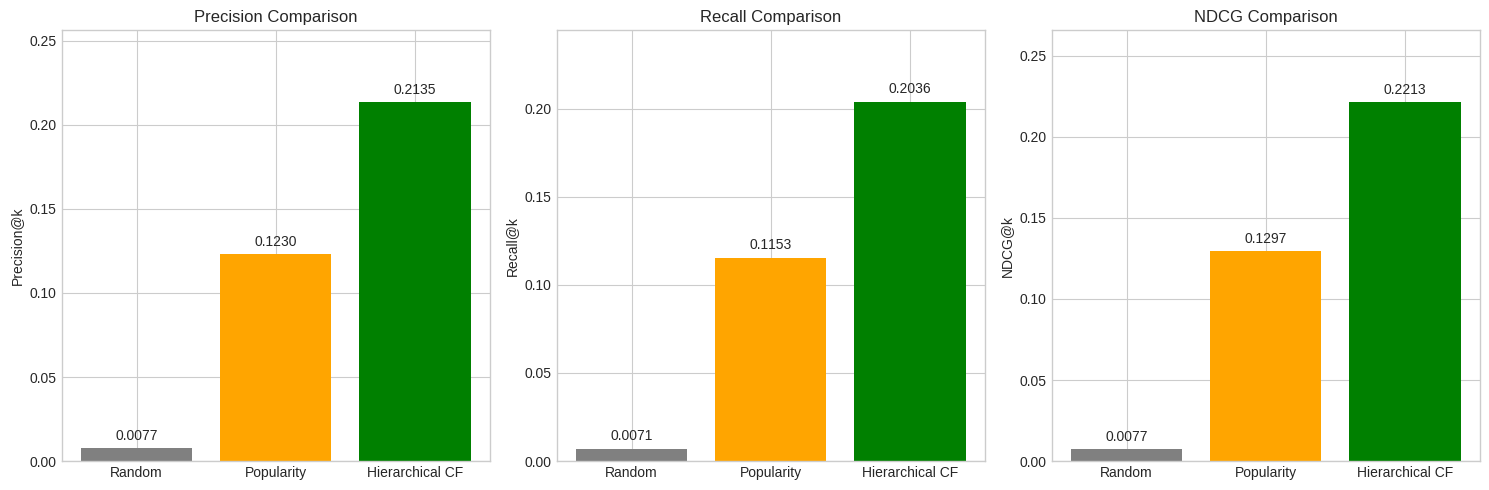

In [69]:
# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = ['Random', 'Popularity', 'Hierarchical CF']
precisions = [random_results['precision'], pop_results['precision'], final_results['precision']]
recalls = [random_results['recall'], pop_results['recall'], final_results['recall']]
ndcgs = [random_results['ndcg'], pop_results['ndcg'], final_results['ndcg']]

# Precision plot
axes[0].bar(models, precisions, color=['gray', 'orange', 'green'])
axes[0].set_ylabel('Precision@k')
axes[0].set_title('Precision Comparison')
axes[0].set_ylim([0, max(precisions) * 1.2])
for i, v in enumerate(precisions):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center')

# Recall plot
axes[1].bar(models, recalls, color=['gray', 'orange', 'green'])
axes[1].set_ylabel('Recall@k')
axes[1].set_title('Recall Comparison')
axes[1].set_ylim([0, max(recalls) * 1.2])
for i, v in enumerate(recalls):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center')

# NDCG plot
axes[2].bar(models, ndcgs, color=['gray', 'orange', 'green'])
axes[2].set_ylabel('NDCG@k')
axes[2].set_title('NDCG Comparison')
axes[2].set_ylim([0, max(ndcgs) * 1.2])
for i, v in enumerate(ndcgs):
    axes[2].text(i, v + 0.005, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()


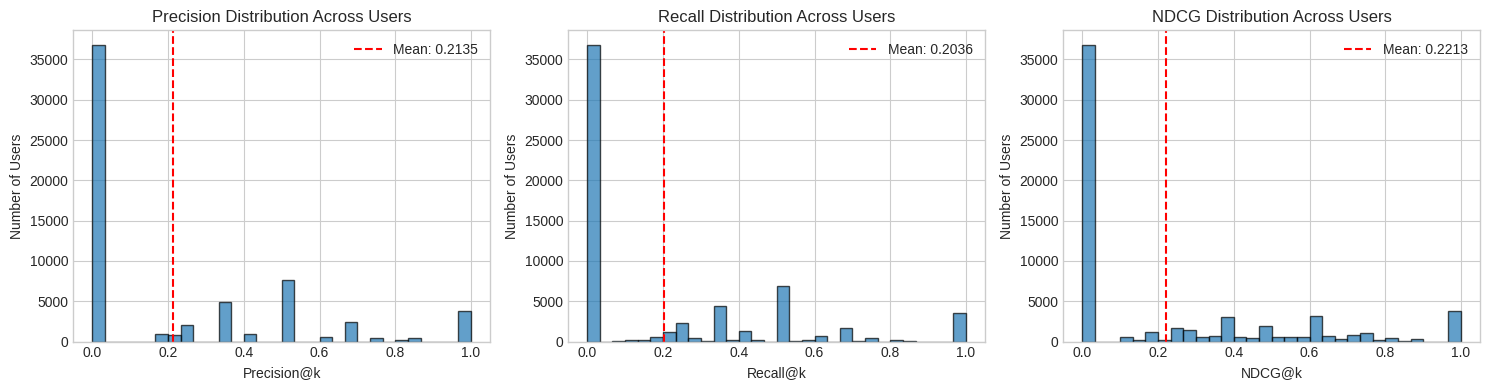

In [70]:
# Distribution of metrics across users
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Precision distribution
axes[0].hist(final_results['precision_all'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(final_results['precision'], color='red', linestyle='--',
                label=f"Mean: {final_results['precision']:.4f}")
axes[0].set_xlabel('Precision@k')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Precision Distribution Across Users')
axes[0].legend()

# Recall distribution
axes[1].hist(final_results['recall_all'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(final_results['recall'], color='red', linestyle='--',
                label=f"Mean: {final_results['recall']:.4f}")
axes[1].set_xlabel('Recall@k')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Recall Distribution Across Users')
axes[1].legend()

# NDCG distribution
axes[2].hist(final_results['ndcg_all'], bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(final_results['ndcg'], color='red', linestyle='--',
                label=f"Mean: {final_results['ndcg']:.4f}")
axes[2].set_xlabel('NDCG@k')
axes[2].set_ylabel('Number of Users')
axes[2].set_title('NDCG Distribution Across Users')
axes[2].legend()

plt.tight_layout()
plt.show()

In [71]:
# Check a few sample users
sample_users = np.random.choice(list(eval_users), size=min(5, len(eval_users)), replace=False)

print("Sample Recommendations:\n")
print("="*80)

for user_idx in sample_users:
    user_id = idx_to_user[user_idx]

    # Get user's test purchases
    test_purchases_idx = test_df[test_df['user_idx'] == user_idx]['comb_idx'].tolist()
    test_purchases_combs = [idx_to_comb[idx] for idx in test_purchases_idx]

    # Get recommendations
    k_user = min(len(test_purchases_idx), 6)
    recs_idx = final_model.recommend(user_idx, k=k_user)
    recs_combs = [idx_to_comb[idx] for idx in recs_idx]

    # Calculate hits
    hits = set(recs_idx) & set(test_purchases_idx)

    print(f"\nCustomer {user_id}:")
    print(f"  Actual purchases in test ({len(test_purchases_idx)}): {test_purchases_combs[:3]}...")
    print(f"  Recommended (top {k_user}): {recs_combs}")
    print(f"  Hits: {len(hits)}/{k_user} (Precision: {len(hits)/k_user:.2f})")

print("\n" + "="*80)

Sample Recommendations:


Customer 12190172015:
  Actual purchases in test (9): [(151.0, 8.0), (251.0, 10.0), (250.0, 10.0)]...
  Recommended (top 6): [(101.0, 8.0), (100.0, 8.0), (100.0, 9.0), (200.0, 9.0), (101.0, 9.0), (150.0, 8.0)]
  Hits: 0/6 (Precision: 0.00)

Customer 11005985111:
  Actual purchases in test (2): [(31.0, 7.0), (31.0, 6.0)]...
  Recommended (top 2): [(31.0, 6.0), (25.0, 6.0)]
  Hits: 1/2 (Precision: 0.50)

Customer 14158121631:
  Actual purchases in test (9): [(31.0, 5.0), (30.0, 5.0), (30.0, 6.0)]...
  Recommended (top 6): [(21.0, 5.0), (20.0, 5.0), (11.0, 5.0), (10.0, 5.0), (3.0, 4.0), (50.0, 5.0)]
  Hits: 3/6 (Precision: 0.50)

Customer 10542692483:
  Actual purchases in test (1): [(11.0, 5.0)]...
  Recommended (top 1): [(20.0, 5.0)]
  Hits: 0/1 (Precision: 0.00)

Customer 10712842595:
  Actual purchases in test (6): [(100.0, 9.0), (51.0, 8.0), (100.0, 9.0)]...
  Recommended (top 6): [(51.0, 8.0), (50.0, 8.0), (50.0, 9.0), (101.0, 8.0), (100.0, 9.0), (101.0, 9.

## Future Improvements

- Optimize both duration and combs together: have k1=k2, and sum the facotrs on **each iteration**. This way, the duration and combs matrices learn together. This may be implemented in LightFM.
- Use a **softer** metric, as some combs are closer to each other than others. For example: the loss of (1, **4**) and (1, **5**) is smaller than the loss of (1, **4**) and (1, **11**). Currenly even if the figures are very close, it is classified as a mismatch.
- Also in metrics, the current metric tends to give lower scores to users who stick with the same combinations, since our recommendations are 6 different combs. For example, this user actual purchases: `[(1, 12), (1, 12), (1, 12)]` by definition gets a low score even though the models top recommendaiton is `(1, 12)`.
- Add additional information, as user meta data, hour and day etc. for better optimization    